# Surface Mass Balance: XGB 

Import relevant Libaries 

In [1]:
%pip install pyarrow
%pip install plotly
%pip install feature_engine
#%pip update pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: unknown command "update"



In [89]:
# Base libraries
import pandas as pd
import numpy as np
import os
import math as math
import datetime
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Visualizations
import matplotlib.pyplot as plt
from matplotlib import pyplot

# TS
from statsmodels.tsa.seasonal import seasonal_decompose

# Set WD
import os
from pyrsistent import v
os.getcwd()
#os.chdir('/Users/asgerlyngeholst-hansen/Desktop/GEUS-Master-Thesis/')
#os.chdir('C:\\Users\\nifu18ab\\Desktop\\GEUS-Master-Thesis')
#os.chdir('/Users/nilsfulde/Desktop/GEUS-Master-Thesis')
#os.chdir('/Users/nilsfulde/Desktop/Master_Thesis')

'/Users/nilsfulde/Desktop/Master_Thesis/scripts'

## Load Stations

In [90]:
# Load Unique Stations
station_list = pd.read_csv(r'../data/promice/stations.csv')

# This bit to define the data that is to be loaded
import glob

# Define the directory path where the CSV files are located
input_path = r'../data/promice/preprocessed/daily/'

# Define a pattern to match the filenames of the CSV files
pattern = '*.csv'

# Use glob to get a list of all files that match the pattern
filenames = glob.glob(input_path + pattern)

dfs = []
for file in filenames:
    df = pd.read_csv(file, index_col=False)
    dfs.append(df)
df = pd.concat(dfs)

In [91]:
#df = df[df['stid'] == 'SCO_L']

In [92]:
stationss = [
'KPC_L',
'SCO_L',
'SCO_U',
'THU_L',
'UPE_L',
'UPE_U',
'MIT',
'TAS_L',
'KAN_L',
'NUK_L',
'NUK_U',
'QAS_L',
'QAS_U',]

df = df[df['stid'].isin(stationss)]

In [93]:
len(df)

68587

## melt onset day / melt end day detection

In [94]:
df["Datetime"] = pd.to_datetime(df["Datetime"], format="%Y-%m-%d")
df['Year'] = df['Datetime'].dt.year
df['DayOfYear'] = df['Datetime'].dt.dayofyear

# Initialize new columns with default values
df['first_melt_day'] = False
df['last_melt_day'] = False

for i in df["stid"].unique().tolist():
    df_station = df[df['stid'] == i]
    unique_years = df_station['Year'].unique()
    for year in unique_years:
        # Filter data for the current year
        year_data = df_station[df_station['Year'] == year]

        # Find the first and last melt day
        first_melt_day = year_data.loc[year_data['Ablation'] == True]['DayOfYear'].min()
        last_melt_day = year_data.loc[year_data['Ablation'] == True]['DayOfYear'].max()

        # Update the original DataFrame
        df.loc[(df['stid'] == i) & (df['Year'] == year) & (df['DayOfYear'] == first_melt_day), 'first_melt_day'] = True
        df.loc[(df['stid'] == i) & (df['Year'] == year) & (df['DayOfYear'] == last_melt_day), 'last_melt_day'] = True
        
        

In [95]:
import pandas as pd

def calculate_time_to_event(df):
    # Initialize an empty DataFrame to store results
    time_to_event_df = pd.DataFrame(columns=df.columns)

    for stid in df['stid'].unique():
        station_df = df[df['stid'] == stid].sort_values(by='Datetime')
        station_df['event_time'] = None

        for year in station_df['Datetime'].dt.year.unique():
            yearly_station_df = station_df[station_df['Datetime'].dt.year == year]
            event_date = None

            for index, row in yearly_station_df.iterrows():
                if row['first_melt_day']:
                    event_date = row['Datetime']
                    break

            if event_date is not None:
                for index, row in yearly_station_df.iterrows():
                    time_to_event = (row['Datetime'] - event_date).days
                    yearly_station_df.loc[index, 'event_time'] = time_to_event

            time_to_event_df = time_to_event_df.append(yearly_station_df)

    return time_to_event_df
df = calculate_time_to_event(df)

df["event_time"] = df["event_time"] * -1

In [96]:
len(df)

68587

In [97]:
df.shape

(68587, 27)

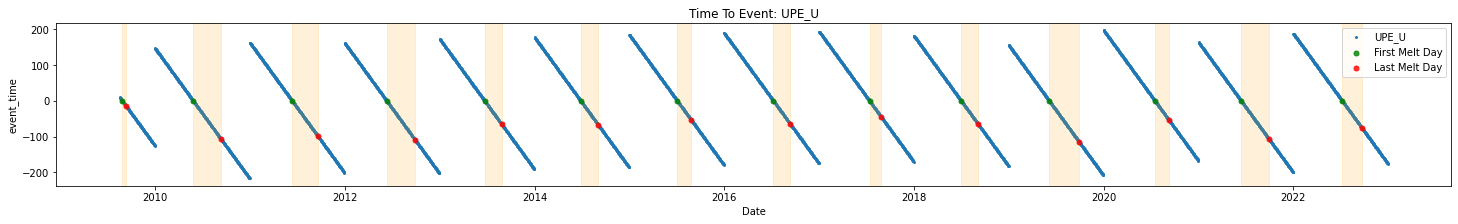

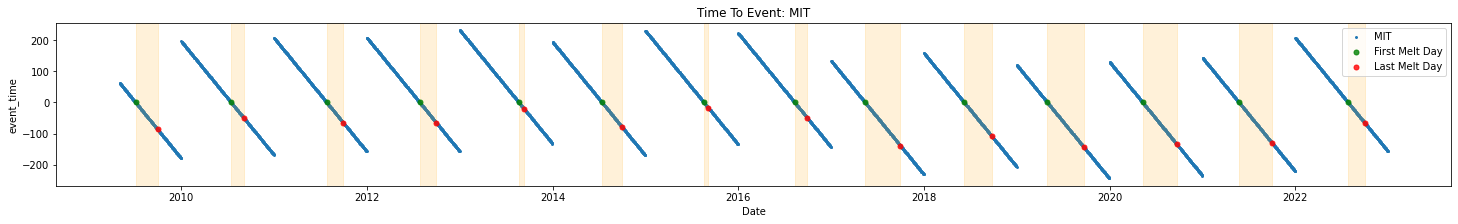

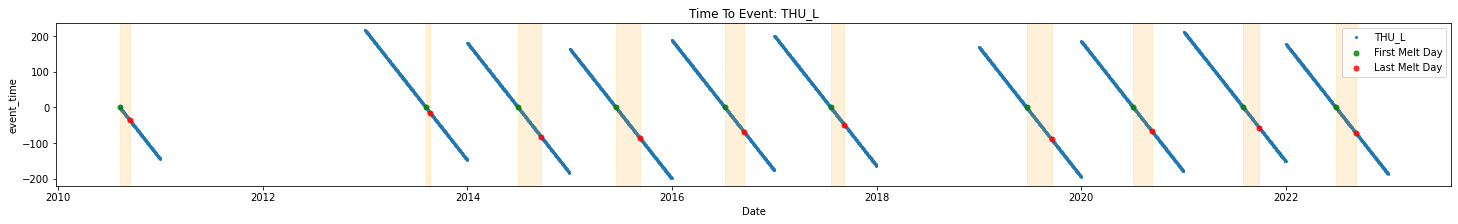

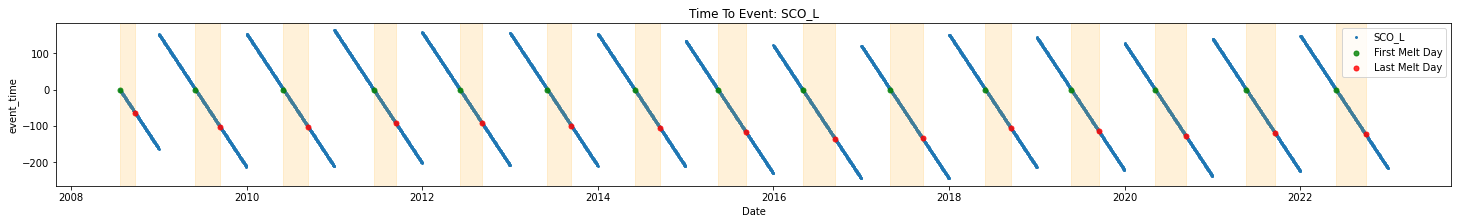

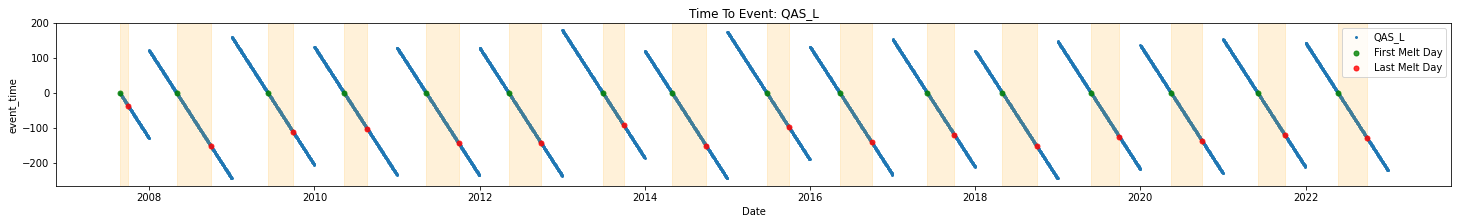

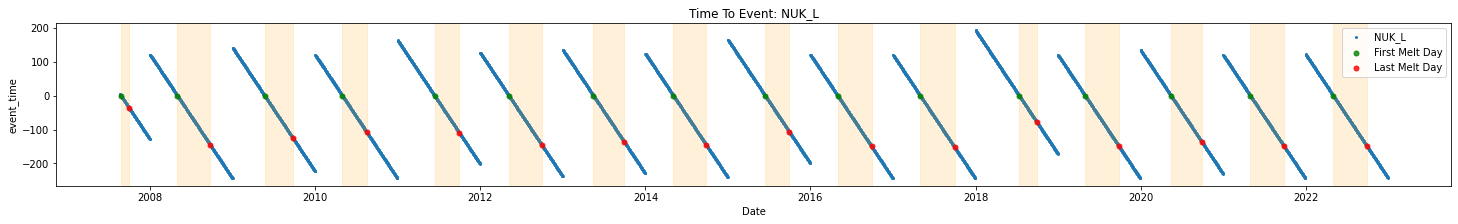

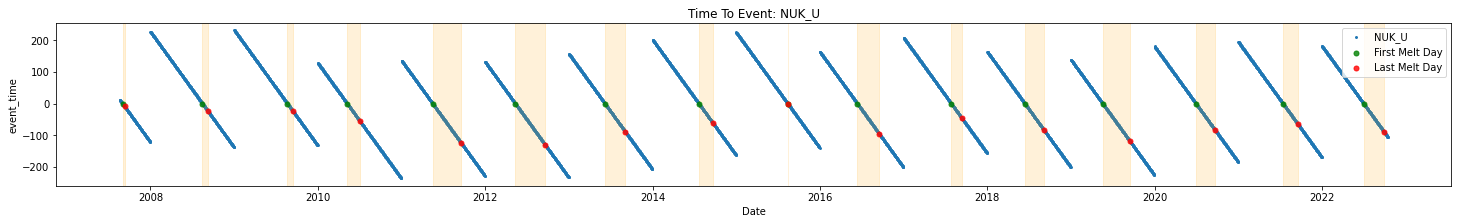

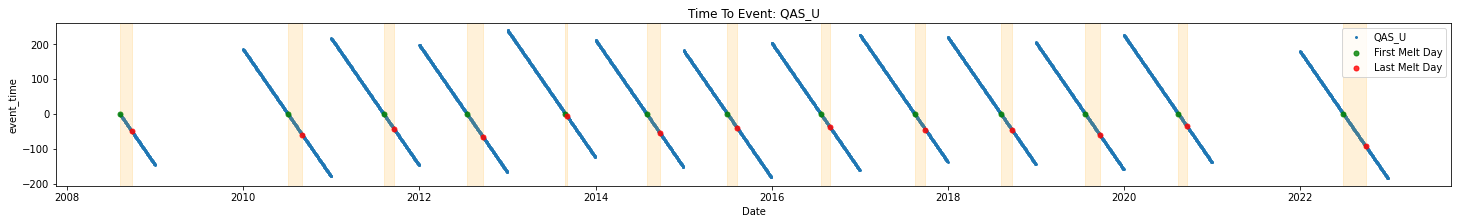

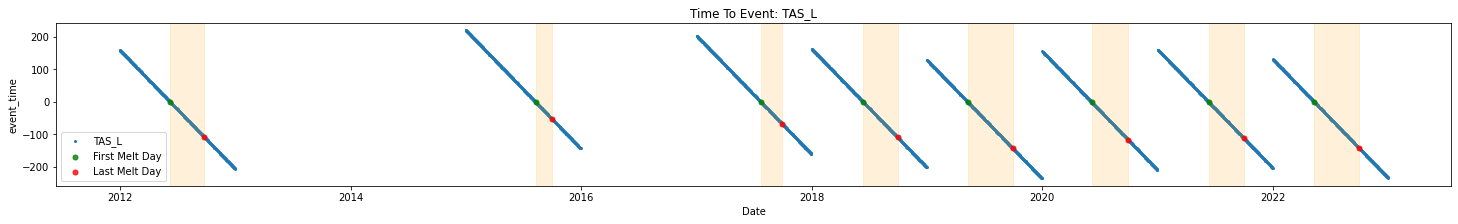

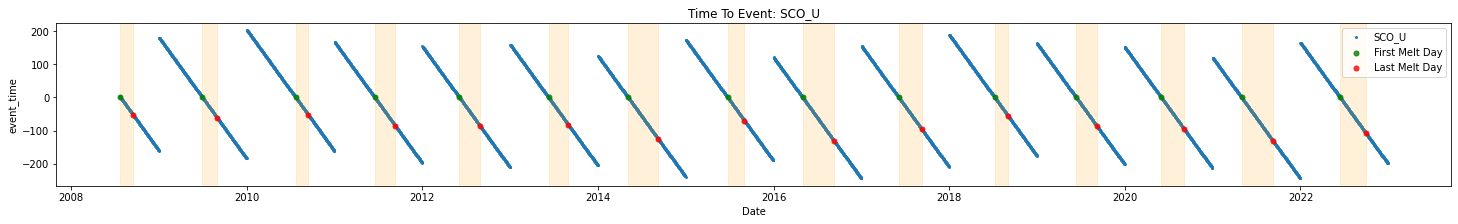

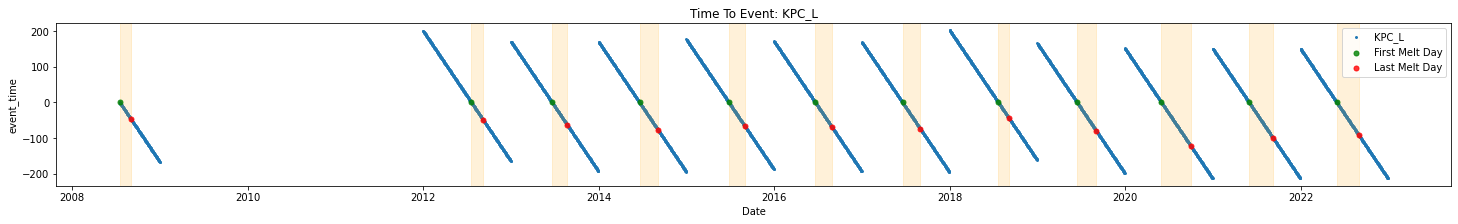

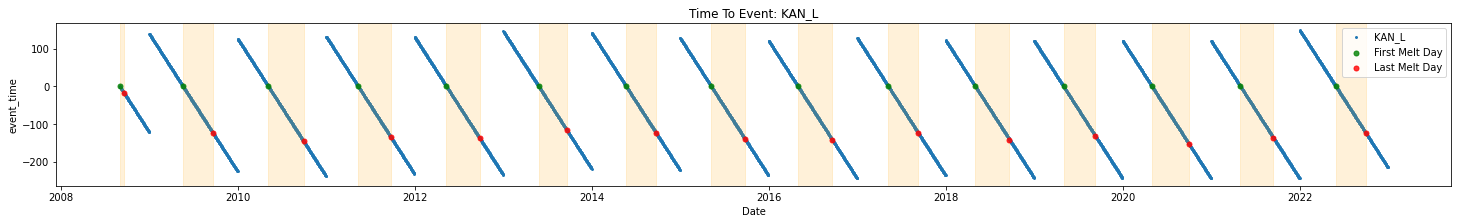

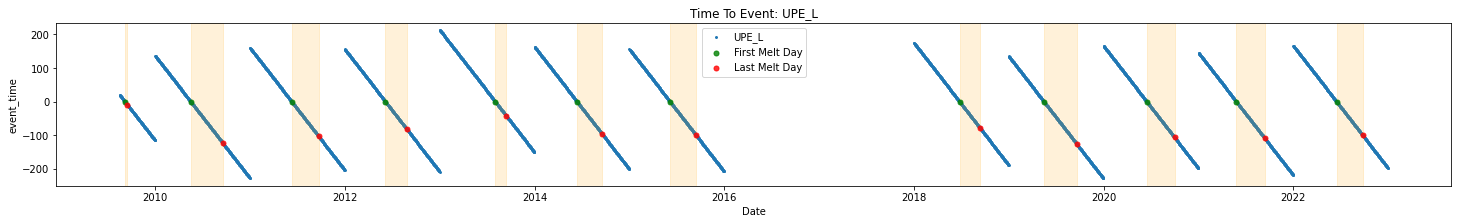

In [98]:
import matplotlib.pyplot as plt
import pandas as pd


for stid in df['stid'].unique():
    station_df = df[df['stid'] == stid]
    
    # filter the dataframe to only include rows where ablation occurred
    ablation_df = station_df[station_df['Ablation'] == True]

    # create a line plot for each station, highlighting the periods of ablation
    fig, ax = plt.subplots(figsize=(25,3))
    
    # Plot the blue scatter points
    plt.scatter(station_df['Datetime'], station_df['event_time'], c='C0',  marker='.', label=stid, s=15)
    
    first_melt_days = station_df[station_df['first_melt_day'] == True]['Datetime']
    last_melt_days = station_df[station_df['last_melt_day'] == True]['Datetime']
    
    for first_day, last_day in zip(first_melt_days, last_melt_days):
        ax.axvspan(first_day, last_day, alpha=0.15, color='orange')
    
    # Plot the first melt day values
    plt.scatter(first_melt_days, station_df.loc[first_melt_days.index, 'event_time'], c='g', alpha=0.8, marker='.', label='First Melt Day', s=100)
    
    # Plot the last melt day values
    plt.scatter(last_melt_days, station_df.loc[last_melt_days.index, 'event_time'], c='r', alpha=0.8 , marker='.', label='Last Melt Day', s=100)

    # set plot title, axis labels and legend
    ax.set_title(f'Time To Event: {stid}')
    ax.set_xlabel('Date')
    ax.set_ylabel('event_time')
    ax.legend()
    
    # Save the plot in the Downloads folder
   # plot_filename = f'Surface_Height_{stid}.png'
   # plt.savefig(os.path.join(os.path.expanduser("~"), "Downloads", plot_filename), dpi=300)
    
plt.show()
    

In [99]:
len(df)

68587

## Regression Analysis

##### Set target variable

In [100]:
y = 'event_time'

In [101]:
len(df)

68587

##### Pre-processing (0.1: Change months to cycle)

In [102]:
# This bit to change the datetime variables into a form that a ML models can understand
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html
    
    
# This bit to split Datetime column into year, month, day, hour columns
df["Datetime"] = pd.to_datetime(df["Datetime"], format="%Y-%m-%d")

#Create new columns
df['year'] = df['Datetime'].dt.year 
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day

#Drop the datetime column
#df.drop(columns=['Datetime'], inplace=True)

In [103]:
len(df)

68587

In [104]:
dfx= df

In [105]:
df=dfx

In [106]:
from feature_engine.creation import CyclicalFeatures

#cyclical = CyclicalFeatures(variables=None, drop_original=True)

# Remove only values from Wind direction because CyclicalFeatures does not work with NA values
#df_wind = df[df['Wind from direction (upper boom)'].notna()]
#cyclical_df = cyclical.fit_transform(df_wind[['Wind from direction (upper boom)']])

# Reset the index for both dataframes
#df.reset_index(drop=True, inplace=True)
#cyclical_df.reset_index(drop=True, inplace=True)

# Update the original dataframe with the transformed wind columns
#for col in cyclical_df.columns:
#    df.loc[df_wind.index, col] = cyclical_df[col]


In [107]:
len(df)

68587

##### Pre-processing (1.0: Filter relevant periods)

In [108]:
df = df[df[y].notna()] 
df = df.reset_index()

In [109]:
len(df)

61645

In [110]:
# Assuming your DataFrame with the 'event_time' column is called 'df_with_time_to_event'
filtered_df = pd.DataFrame(columns=df.columns)

for stid in df['stid'].unique():
    station_df = df[df['stid'] == stid]

    for year in station_df['Datetime'].dt.year.unique():
        yearly_station_df = station_df[station_df['Datetime'].dt.year == year]

        # Exclude observations after the day of event
        yearly_station_df = yearly_station_df[yearly_station_df['event_time'] >= 0]

        filtered_df = filtered_df.append(yearly_station_df)
df = filtered_df

In [111]:
len(df)

27017

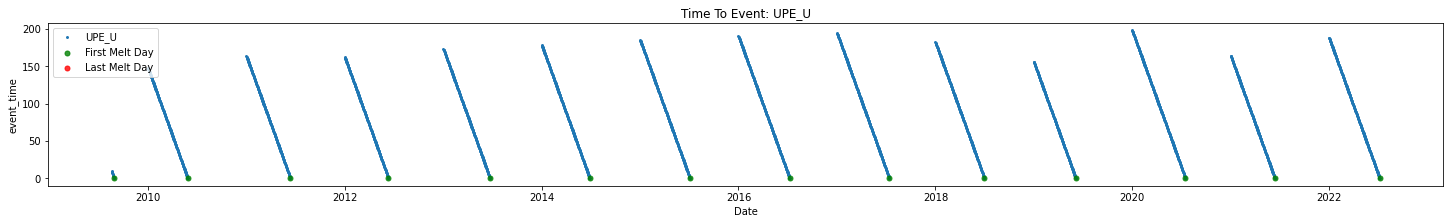

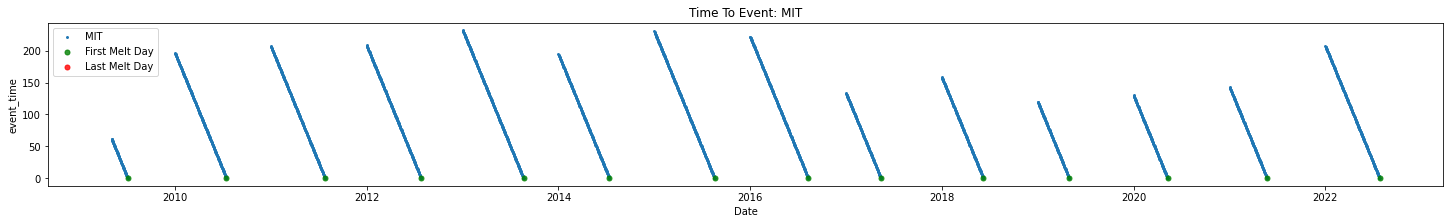

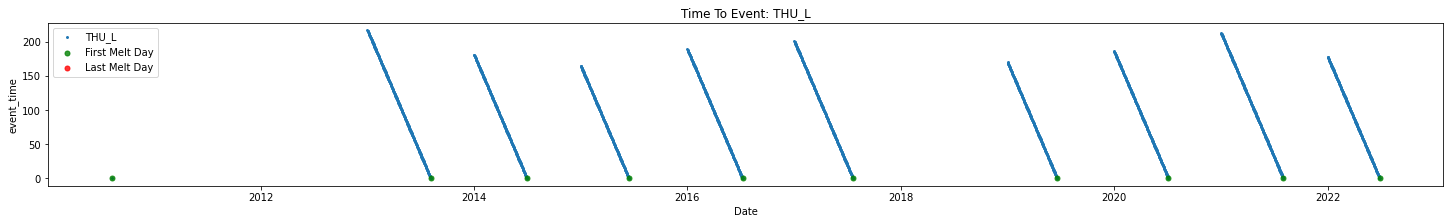

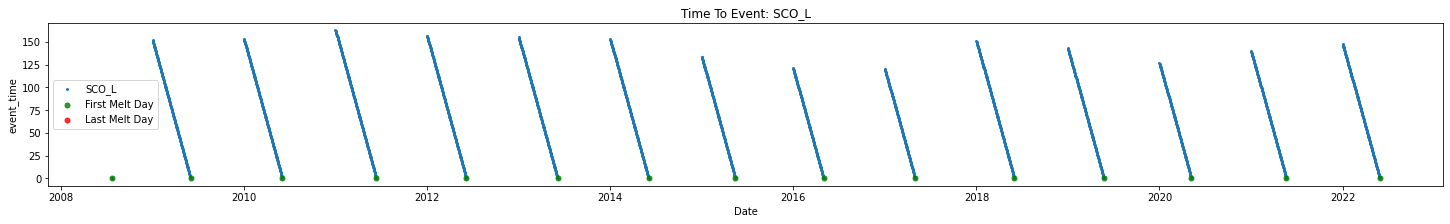

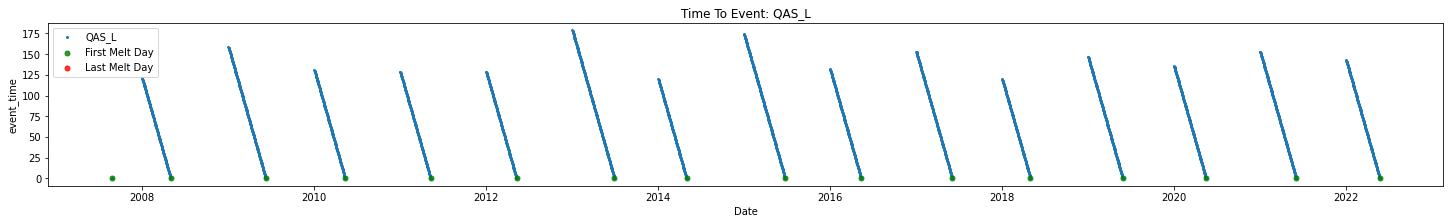

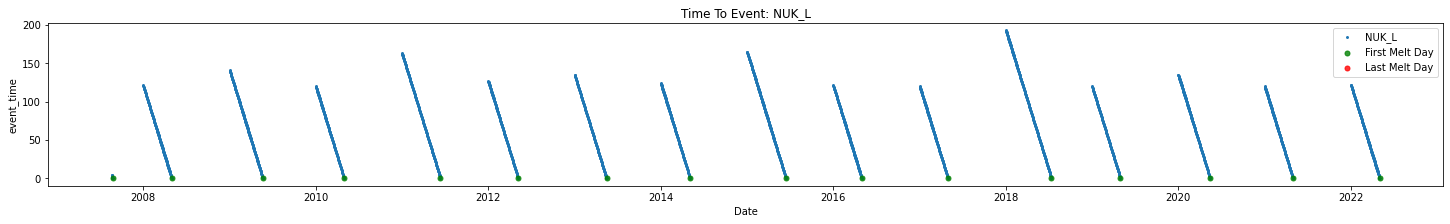

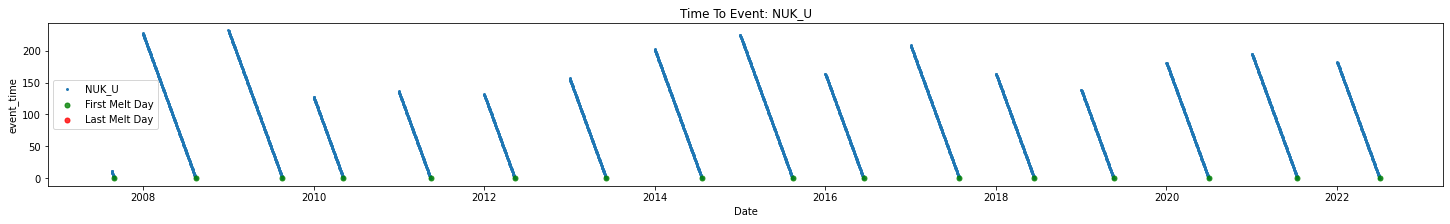

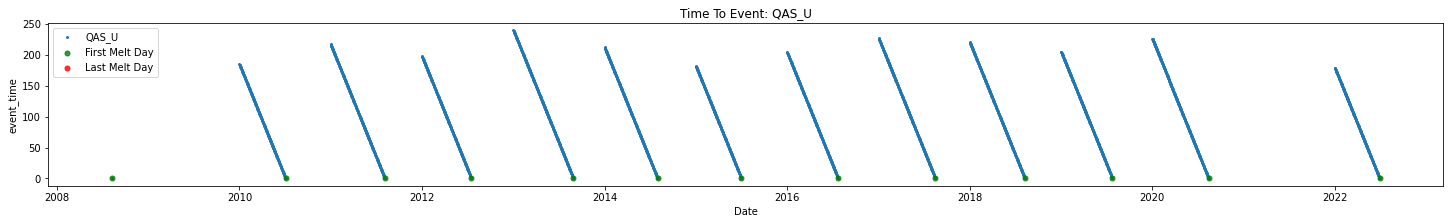

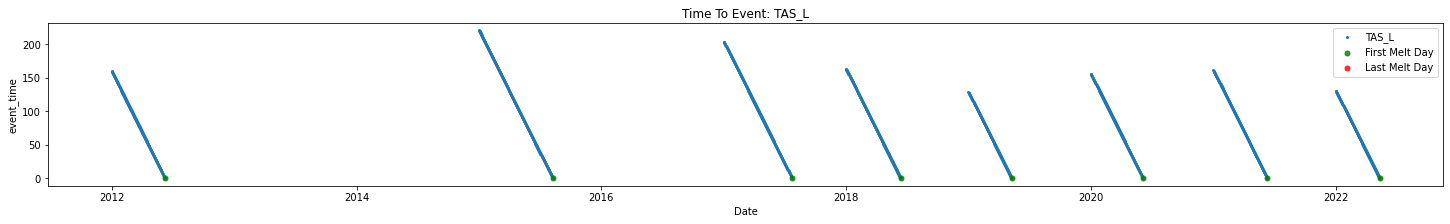

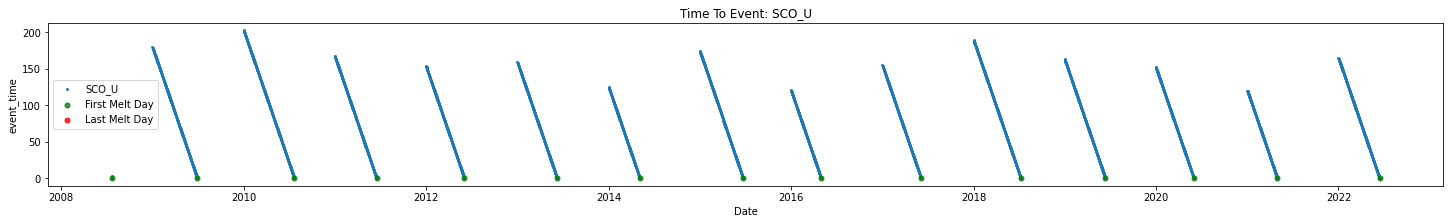

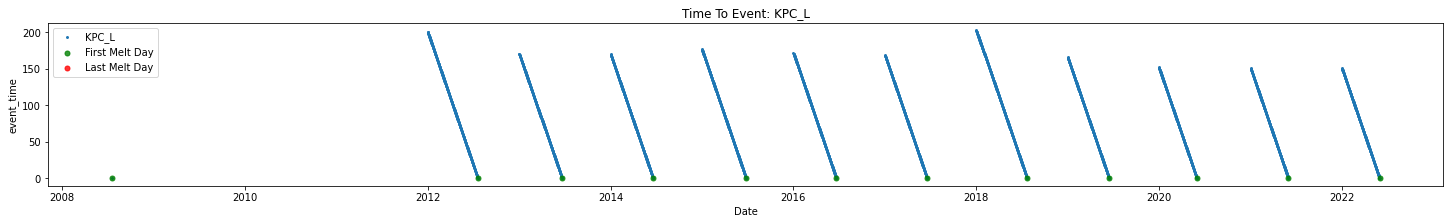

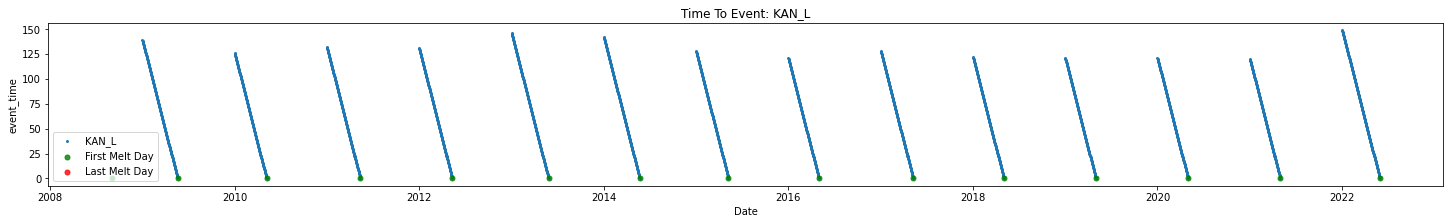

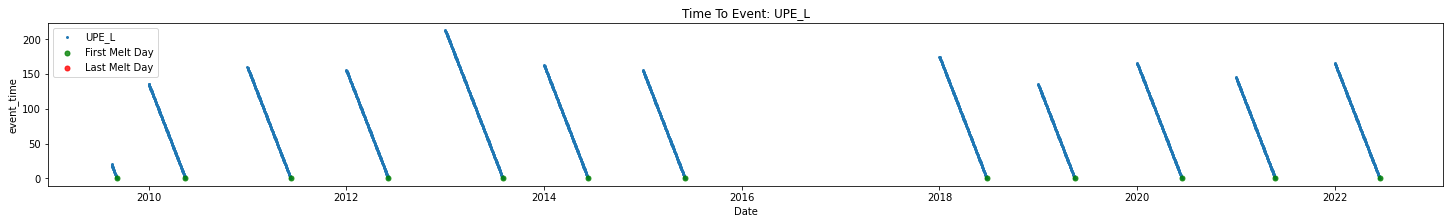

In [112]:
import matplotlib.pyplot as plt
import pandas as pd


for stid in df['stid'].unique():
    station_df = df[df['stid'] == stid]
    
    # filter the dataframe to only include rows where ablation occurred
    ablation_df = station_df[station_df['Ablation'] == True]

    # create a line plot for each station, highlighting the periods of ablation
    fig, ax = plt.subplots(figsize=(25,3))
    
    # Plot the blue scatter points
    plt.scatter(station_df['Datetime'], station_df['event_time'], c='C0',  marker='.', label=stid, s=15)
    
    first_melt_days = station_df[station_df['first_melt_day'] == True]['Datetime']
    last_melt_days = station_df[station_df['last_melt_day'] == True]['Datetime']
    
    for first_day, last_day in zip(first_melt_days, last_melt_days):
        ax.axvspan(first_day, last_day, alpha=0.15, color='orange')
    
    # Plot the first melt day values
    plt.scatter(first_melt_days, station_df.loc[first_melt_days.index, 'event_time'], c='g', alpha=0.8, marker='.', label='First Melt Day', s=100)
    
    # Plot the last melt day values
    plt.scatter(last_melt_days, station_df.loc[last_melt_days.index, 'event_time'], c='r', alpha=0.8 , marker='.', label='Last Melt Day', s=100)

    # set plot title, axis labels and legend
    ax.set_title(f'Time To Event: {stid}')
    ax.set_xlabel('Date')
    ax.set_ylabel('event_time')
    ax.legend()
    
    # Save the plot in the Downloads folder
   # plot_filename = f'Surface_Height_{stid}.png'
   # plt.savefig(os.path.join(os.path.expanduser("~"), "Downloads", plot_filename), dpi=300)
    
plt.show()
    

##### Pre-processing (2.0: Formatting and transformation)

In [113]:
from sklearn.preprocessing import LabelEncoder
 
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
df['stid'] = le.fit_transform(df['stid'])
station_names = dict(zip(le.classes_, le.transform(le.classes_)))

In [114]:
# This bit to include only relevant features
exclude_list = ['index', # excluded because of unimportant information
                #'stid', 
                'Unnamed: 0', # Old Index
                'ID',
                #'Wind from direction (upper boom)',
                'Ablation',
                'Melting Season', # We drop melting season later 
                'month',
                'month_sin',
                'month_cos',
                'day', 
                'day_sin',
                'day_cos',
                'hour', 
                'year',
                'year_sin',
                'year_cos'
                'subgroup',
                'Surface height from combined measurements',
                'Surface height from combined measurements DELTA',
                'observed', 
                'residual', 
                'seasonal', 
                'trend',
                'residual_smoothed',
                'Periods',
                'Year',
                'first_melt_day',
                'last_melt_day',
                'DayOfYear',
                'Datetime',
                #'event_time',
                'seasonal_residual'
               ]



df = df[[column for column in df.columns if column not in exclude_list]]
data = df.copy()

In [115]:
# This bit to convert all numerical values into the same scale 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]

# Exclude whater is not needed for scaling
exlude_num = ['stid', 
              'ID',
              'Surface height from combined measurements', 
              'Surface height from combined measurements DELTA',
              'month_sin',
              'month_cos',
              'month',
              'day', 
              'day_sin',
              'day_cos',
              'hour', 
              'year',
              'year_sin',
              'year_cos'
              'subgroup',
              'Surface height from combined measurements',
              'Surface height from combined measurements DELTA',
              'observed', 
              'residual', 
              'seasonal', 
              'trend',
              'Wind from direction (upper boom)',
              'Wind from direction (upper boom)_sin',
              'Wind from direction (upper boom)_cos',
              'seasonal_residual',
              'residual_smoothed',
              'Datetime',
              'event_time'
             ]


num_cols = df.select_dtypes(include=['int64','float64'])
num_cols = num_cols[[column for column in num_cols.columns if column not in exlude_num]].columns

scaler = MinMaxScaler()

#fit and transform numerical columns
df[num_cols] = scaler.fit_transform(df[num_cols])
data[num_cols] = scaler.fit_transform(data[num_cols])

In [116]:
df.shape

(27017, 17)

In [117]:
## This bit only for baseline models
df_base = df
df_base['Albedo'] = df_base['Albedo'].fillna(method='bfill')
df_base = df_base.dropna()

from sklearn.model_selection import train_test_split

# Get unique stid values
stid_values = df_base['stid'].unique()

# Initialize empty lists to store train and test data
X_train, X_test, y_train, y_test = [], [], [], []

# Loop through each stid value and split the data into train and test sets
for stid in stid_values:
    # Get rows corresponding to the current stid value
    subset_df_base = df_base[df_base['stid'] == stid]
    
    # Split the subset into train and test sets
    X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(
        subset_df_base.drop([y], axis=1), subset_df_base[y], test_size=0.3, random_state=123, shuffle =True)
    
    # Append the train and test data to the lists
    X_train.append(X_train_subset)
    X_test.append(X_test_subset)
    y_train.append(y_train_subset)
    y_test.append(y_test_subset)

# Concatenate the train and test data into a single dataframe
X_train_base = pd.concat(X_train)
X_test_base = pd.concat(X_test)
y_train_base = pd.concat(y_train)
y_test_base = pd.concat(y_test)

In [118]:
len(X_train_base) + len(X_test_base)

20082

In [119]:
# This bit for XGB models
# Get unique stid values
stid_values = df['stid'].unique()

# Initialize empty lists to store train and test data
X_train, X_test, y_train, y_test = [], [], [], []

# Loop through each stid value and split the data into train and test sets
for stid in stid_values:
    # Get rows corresponding to the current stid value
    subset_df = df[df['stid'] == stid]
    
    # Split the subset into train and test sets
    X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(
        subset_df.drop([y], axis=1), subset_df[y], test_size=0.3, random_state=123, shuffle =True)
    
    # Append the train and test data to the lists
    X_train.append(X_train_subset)
    X_test.append(X_test_subset)
    y_train.append(y_train_subset)
    y_test.append(y_test_subset)

# Concatenate the train and test data into a single dataframe
X_train = pd.concat(X_train)
X_test = pd.concat(X_test)
y_train = pd.concat(y_train)
y_test = pd.concat(y_test)

In [120]:
len(df)

27017

In [121]:
len(X_train) + len(X_test)

27017

In [122]:
X_train.columns

Index(['stid', 'Air pressure (upper boom)', 'Air temperature (upper boom)',
       'Relative humidity (upper boom) - corrected',
       'Specific humidity (upper boom)', 'Wind speed (upper boom)',
       'Wind from direction (upper boom)',
       'Downwelling shortwave radiation - corrected',
       'Upwelling shortwave radiation - corrected',
       'Downwelling longwave radiation', 'Upwelling longwave radiation',
       'Surface temperature', 'Latent heat flux (upper boom)',
       'Sensible heat flux (upper boom)', 'Albedo', 'Cloud cover'],
      dtype='object')

In [123]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit

cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=123)

## Regression Modelling

-------

## Selected Models

In [124]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_hist_gradient_boosting  # Required to enable HistGradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
import xgboost as xgb
from sklearn.metrics import r2_score
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [130]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_absolute_error')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

[CV] END ................................fit_intercept=False; total time=   3.9s
[CV] END ................................fit_intercept=False; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END ................................fit_intercept=False; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END ................................fit_intercept=False; total time=   0.0s
[CV] END ................................fit_intercept=False; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END .................................fit_intercept=True; total time=   0.0s
[CV] END ................................fit_intercept=False; total time=   0.0s
[CV 1/5] END colsample_bytree=0.9, gamma=0, learning_rate=0.05, max_depth=15, min_child_weight=10, subsample=0.8;, score=0.916 total time=   6.8s
[CV] END .................................fi

In [126]:
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    for ii, (tr, tt) in enumerate(cv.split(X, y)):
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        ax.scatter(range(len(indices)), [ii + 0.5] * len(indices), c=indices, marker="_", lw=lw, cmap=plt.cm.coolwarm, vmin=-0.2, vmax=1.2)

    ax.set_xlabel("Sample index")
    ax.set_ylabel("CV iteration")
    ax.set_yticks(np.arange(n_splits) + 0.5)
    ax.set_yticklabels(list(range(n_splits)))
    ax.set_title("{}".format(type(cv).__name__))
    return ax

In [127]:
def plot_validation_curve(estimator, title, X, y, param_name, param_range, cv=None, n_jobs=-1, log_scale=False):
    train_scores, test_scores = validation_curve(estimator, X, y, param_name=param_name, param_range=param_range, cv=cv, n_jobs=n_jobs)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel(f"{param_name}")
    plt.ylabel("Score")
    plt.grid()

    if log_scale:
        plt.xscale("log")

    plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(param_range, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(param_range, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best hyperparameters: {'fit_intercept': True}
Average Mean Absolute Error test score from cv : -24.839823650887933
Standard deviation of Mean Absolute Error test scores from cv: 0.1967694587253768


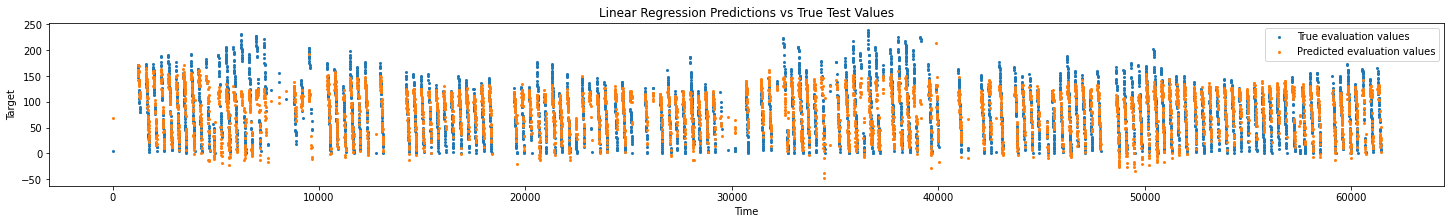

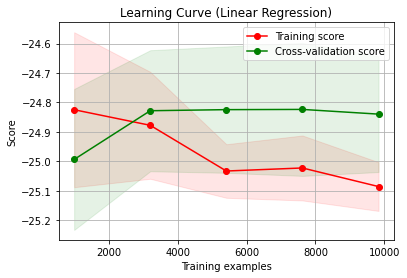

------------------------------------------------------------------------------------
Mean Absolute Error score on validation set (event_time):  24.86043799155849
------------------------------------------------------------------------------------
KAN_L
Mean Absolute Error score on test set (event_time):  29.022463341280766


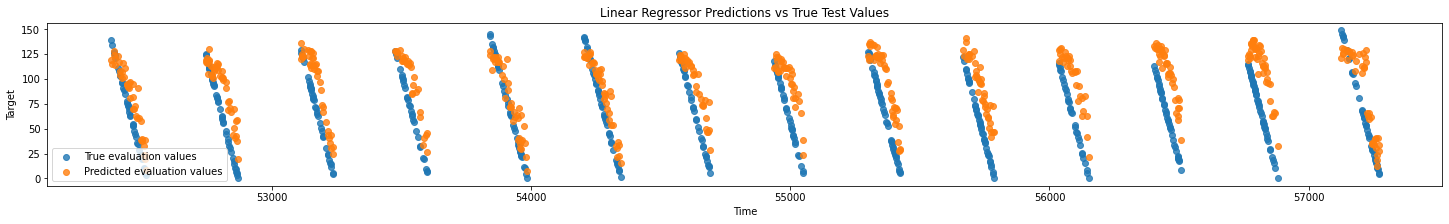

------------------------------------------------------------------------------------
KPC_L
Mean Absolute Error score on test set (event_time):  22.337717599391716


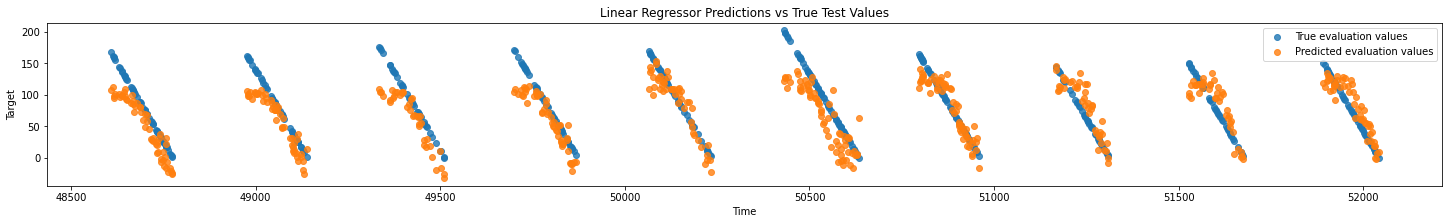

------------------------------------------------------------------------------------
MIT
Mean Absolute Error score on test set (event_time):  45.060736663338005


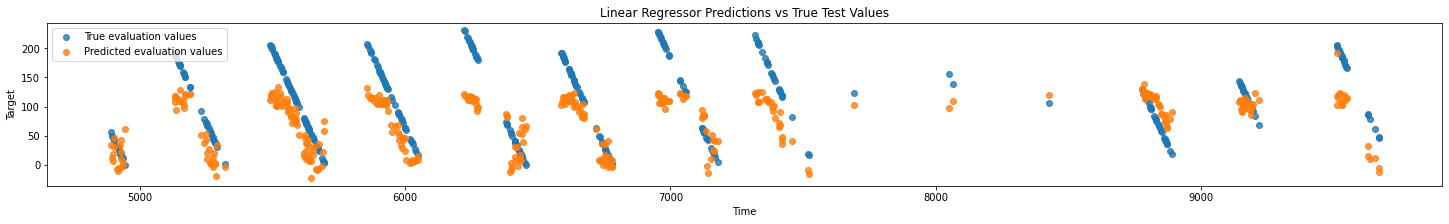

------------------------------------------------------------------------------------
NUK_L
Mean Absolute Error score on test set (event_time):  25.40918983763048


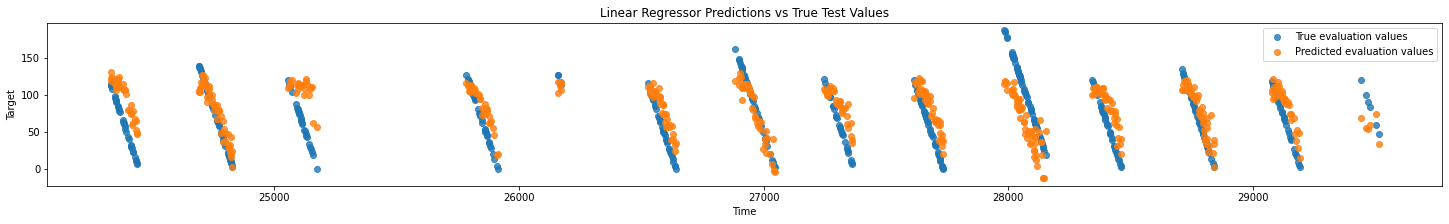

------------------------------------------------------------------------------------
NUK_U
Mean Absolute Error score on test set (event_time):  26.82452844398552


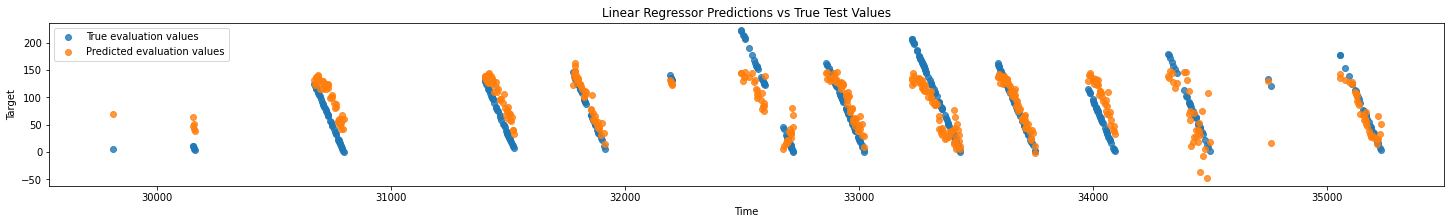

------------------------------------------------------------------------------------
QAS_L
Mean Absolute Error score on test set (event_time):  20.39290504410509


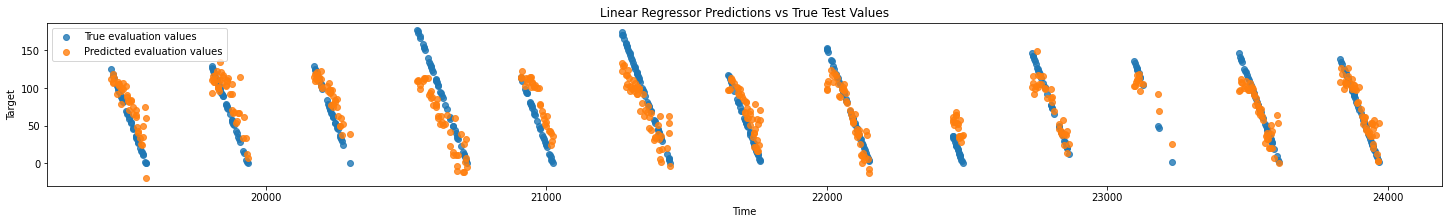

------------------------------------------------------------------------------------
QAS_U
Mean Absolute Error score on test set (event_time):  37.59779985617934


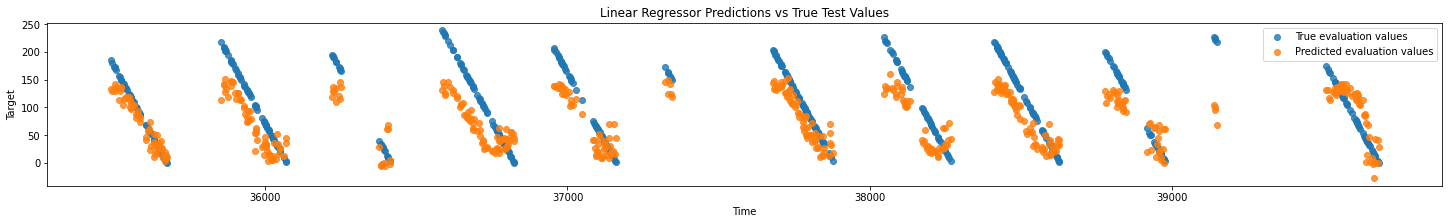

------------------------------------------------------------------------------------
SCO_L
Mean Absolute Error score on test set (event_time):  20.36228427236902


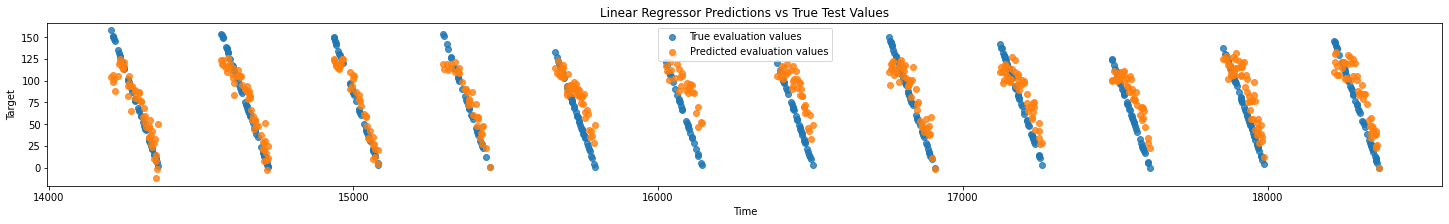

------------------------------------------------------------------------------------
SCO_U
Mean Absolute Error score on test set (event_time):  19.083677718958377


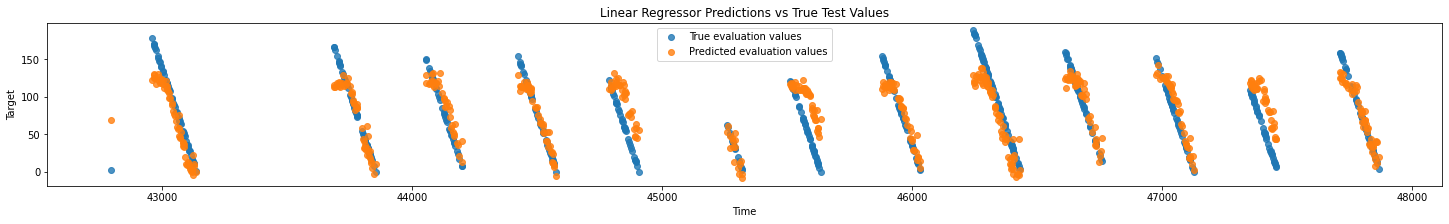

------------------------------------------------------------------------------------
TAS_L
Mean Absolute Error score on test set (event_time):  22.369617748248615


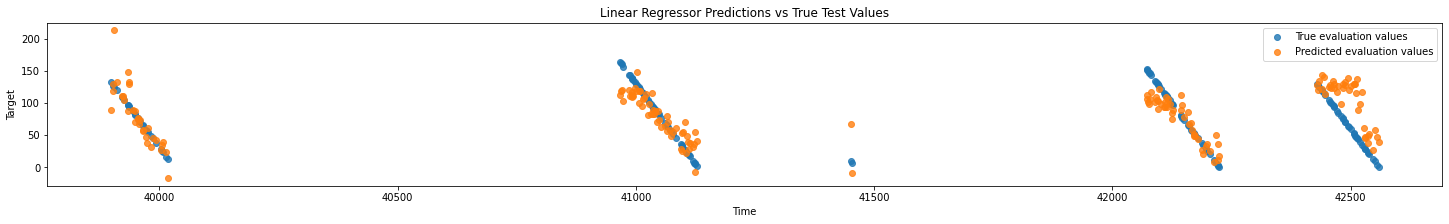

------------------------------------------------------------------------------------
THU_L
Mean Absolute Error score on test set (event_time):  16.69143266380109


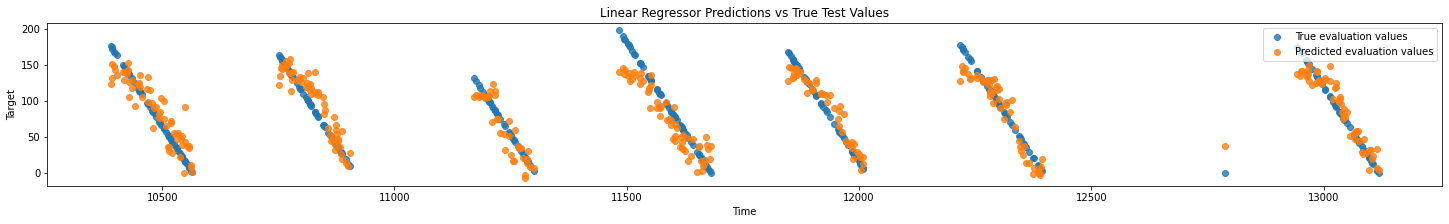

------------------------------------------------------------------------------------
UPE_L
Mean Absolute Error score on test set (event_time):  19.636258981123444


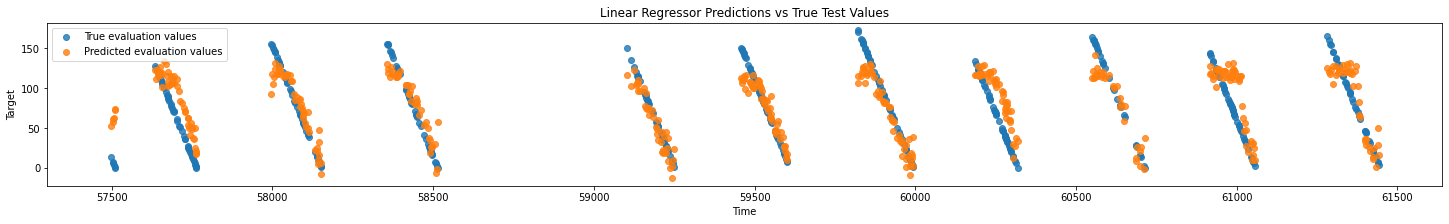

------------------------------------------------------------------------------------
UPE_U
Mean Absolute Error score on test set (event_time):  17.490767785542204


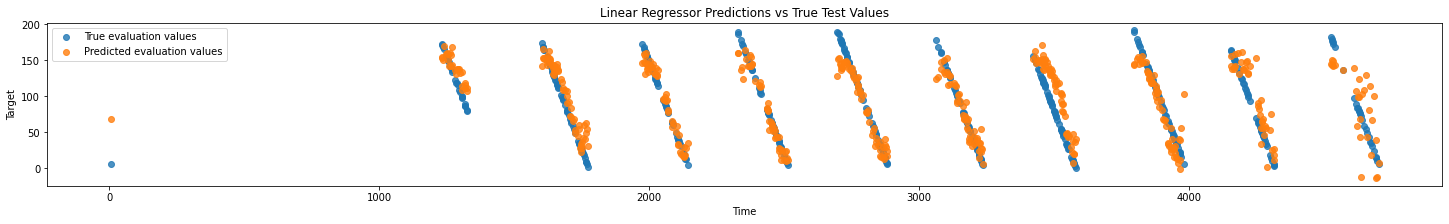

In [128]:
# Linear Regression

# Train the linear regression model
lr_model = LinearRegression()
# Define hyperparameter search space
param_grid = {
    'fit_intercept': [True, False]
 #   'normalize': [True, False]
}

# Create grid search object
grid_search = GridSearchCV(lr_model, param_grid, cv=cv, n_jobs=-1, verbose=2, scoring="neg_mean_absolute_error")

# Fit the grid search object to the training data
grid_search.fit(X_train_base, y_train_base)

# Get the best estimator
best_lr_model = grid_search.best_estimator_
best_estimator = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_base = best_lr_model.predict(X_test_base)

mae = mean_absolute_error(y_test_base, y_pred_base)

print("Best hyperparameters:", grid_search.best_params_)
print("Average Mean Absolute Error test score from cv :", grid_search.cv_results_["mean_test_score"][0])
print("Standard deviation of Mean Absolute Error test scores from cv:", grid_search.cv_results_["std_test_score"][0])

plt.figure(figsize=(25, 3))
plt.scatter(X_test_base.index, y_test_base, label="True evaluation values", alpha=1, s=4)
plt.scatter(X_test_base.index, y_pred_base, label="Predicted evaluation values", alpha=1, s=4)

plt.xlabel("Time")
plt.ylabel("Target")
plt.title("Linear Regression Predictions vs True Test Values")
plt.legend()
plt.show()

plot_learning_curve(best_estimator, "Learning Curve (Linear Regression)", X_train_base, y_train_base, cv=cv)
plt.show()

print('------------------------------------------------------------------------------------')
print(f"Mean Absolute Error score on validation set ({y}): ", mae)

for value, station_name in enumerate(station_names):
    print('------------------------------------------------------------------------------------')
    print(station_name)

    # Subset X_train and X_test with the values of station_names
    X_train_station = X_train_base.loc[X_train_base['stid'] == value]
    X_test_station = X_test_base.loc[X_test_base['stid'] == value]

    # Subset y_train and y_test with the indices of X_train
    y_train_station = y_train_base.loc[X_train_station.index]
    y_test_station = y_test_base.loc[X_test_station.index]

    y_pred_station = best_lr_model.predict(X_test_station)
    mae_station = mean_absolute_error(y_test_station, y_pred_station)
    
    print(f"Mean Absolute Error score on test set ({y}): ", mae_station)
    
    plt.figure(figsize=(25, 3))
    plt.scatter(X_test_station.index, y_test_station, label="True evaluation values", alpha=0.8)
    plt.scatter(X_test_station.index, y_pred_station, label="Predicted evaluation values", alpha=0.8)
    plt.xlabel("Time")
    plt.ylabel("Target")
    plt.title("Linear Regressor Predictions vs True Test Values")
    plt.legend()
    plt.show()
    

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters_event_time:  {'colsample_bytree': 0.9, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 15, 'min_child_weight': 10, 'subsample': 0.8}
------------------------------------------------------------------------------------
Average Mean Absolute Error test score from cv : -10.958007331545229
Standard deviation of Mean Absolute Error test scores from cv: 0.07004951108879738


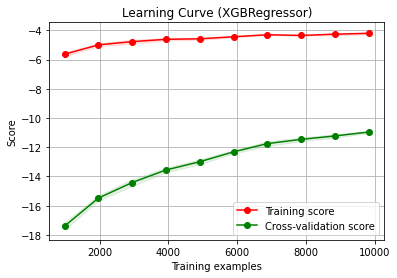

------------------------------------------------------------------------------------
MAE on validation set (event_time):  10.135724614785481


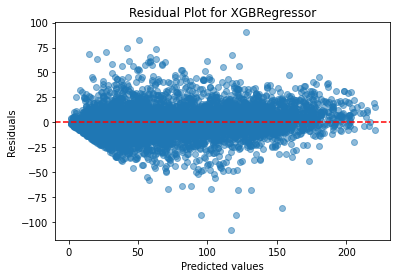

------------------------------------------------------------------------------------
KAN_L
Mean Absolute Error on test set (event_time):  6.60642567017804


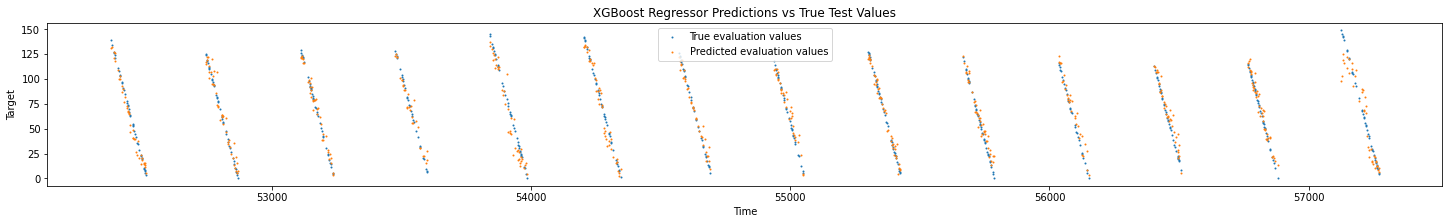

------------------------------------------------------------------------------------
KPC_L
Mean Absolute Error on test set (event_time):  6.670519322215457


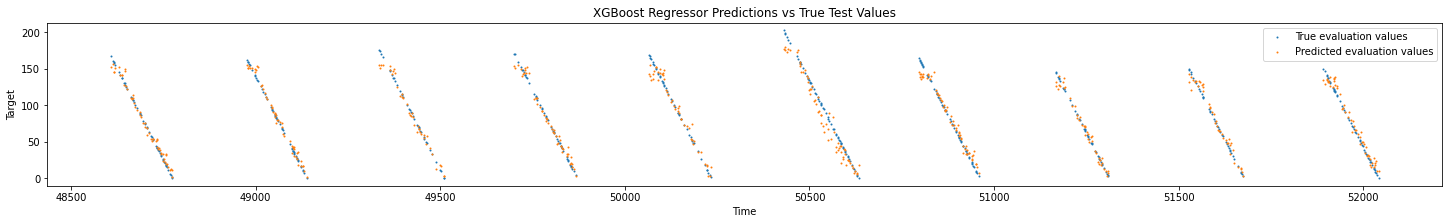

------------------------------------------------------------------------------------
MIT
Mean Absolute Error on test set (event_time):  13.958932257535166


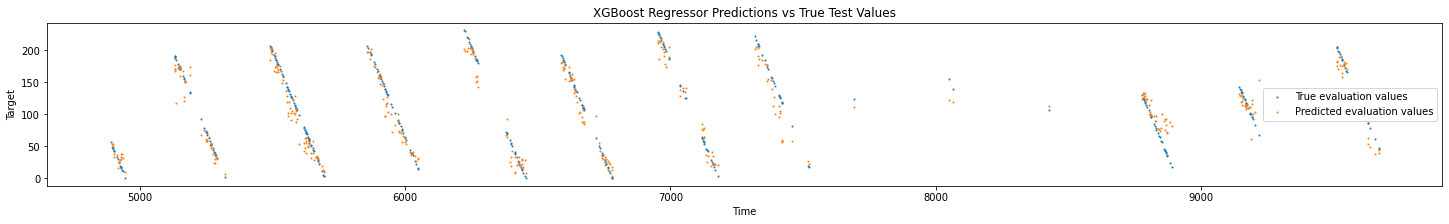

------------------------------------------------------------------------------------
NUK_L
Mean Absolute Error on test set (event_time):  13.284741517516874


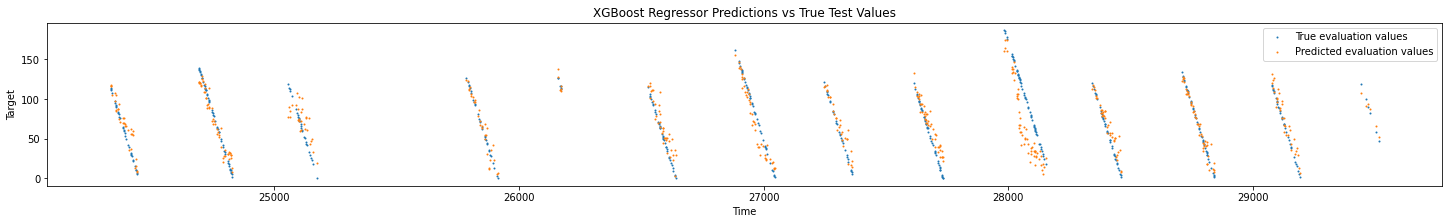

------------------------------------------------------------------------------------
NUK_U
Mean Absolute Error on test set (event_time):  14.934328303066403


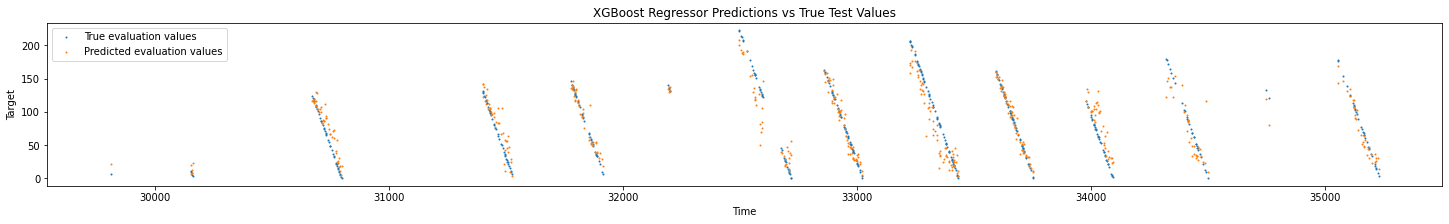

------------------------------------------------------------------------------------
QAS_L
Mean Absolute Error on test set (event_time):  12.604632742778833


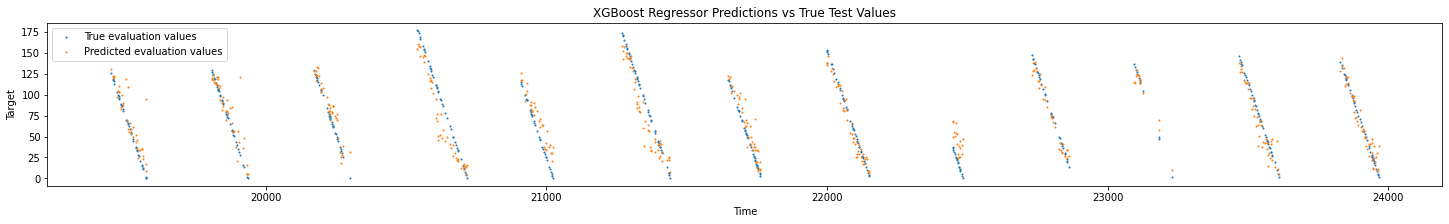

------------------------------------------------------------------------------------
QAS_U
Mean Absolute Error on test set (event_time):  12.625519219976272


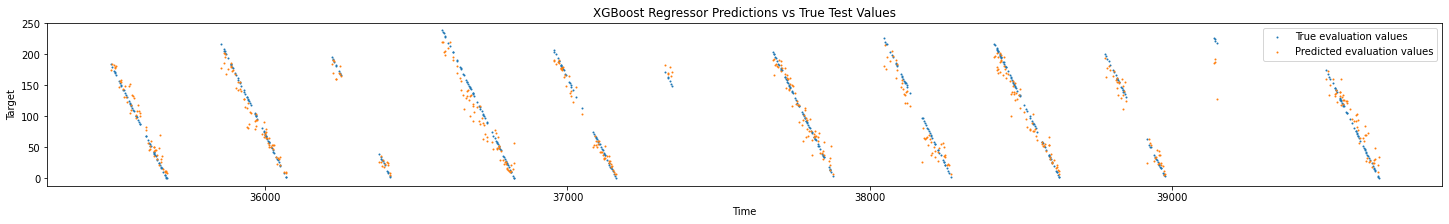

------------------------------------------------------------------------------------
SCO_L
Mean Absolute Error on test set (event_time):  5.9847042227254335


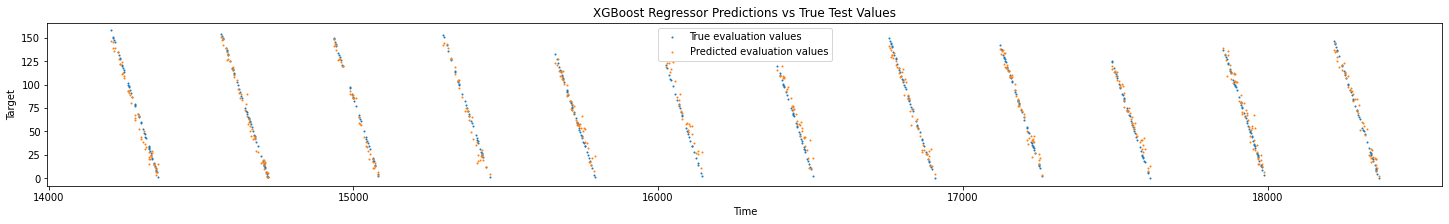

------------------------------------------------------------------------------------
SCO_U
Mean Absolute Error on test set (event_time):  8.588071371152482


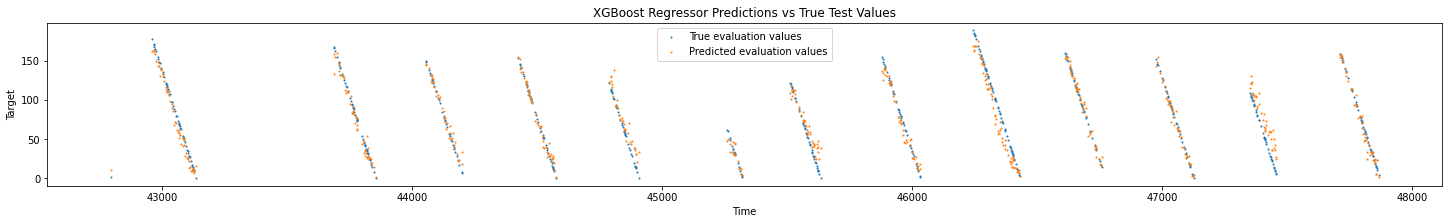

------------------------------------------------------------------------------------
TAS_L
Mean Absolute Error on test set (event_time):  12.337187597307109


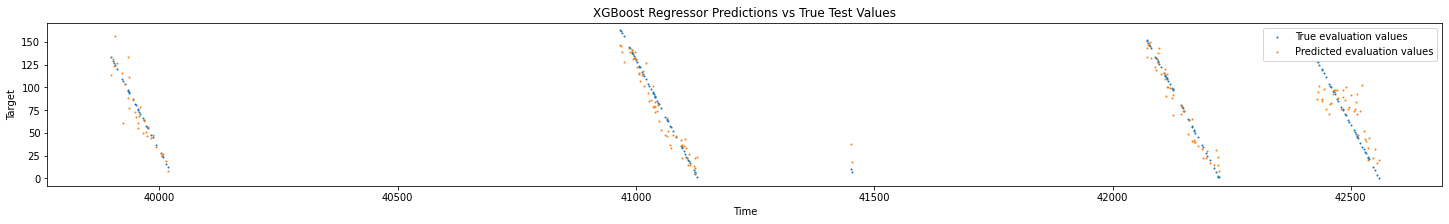

------------------------------------------------------------------------------------
THU_L
Mean Absolute Error on test set (event_time):  8.30892523435446


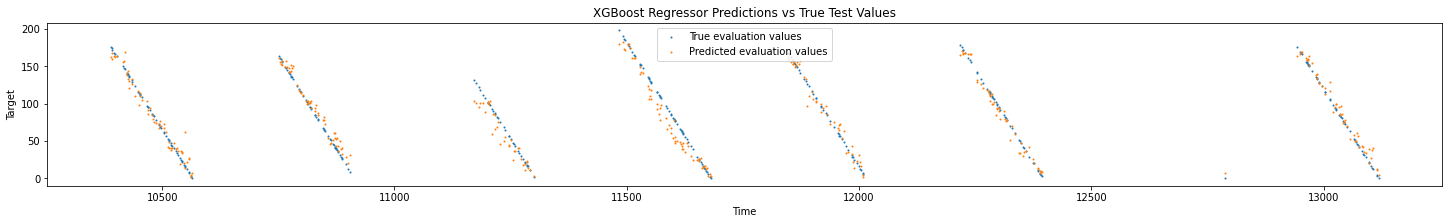

------------------------------------------------------------------------------------
UPE_L
Mean Absolute Error on test set (event_time):  9.076006289401086


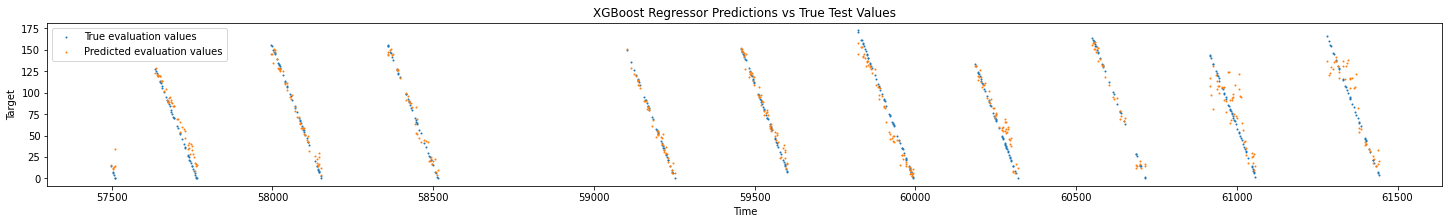

------------------------------------------------------------------------------------
UPE_U
Mean Absolute Error on test set (event_time):  9.404001742477734


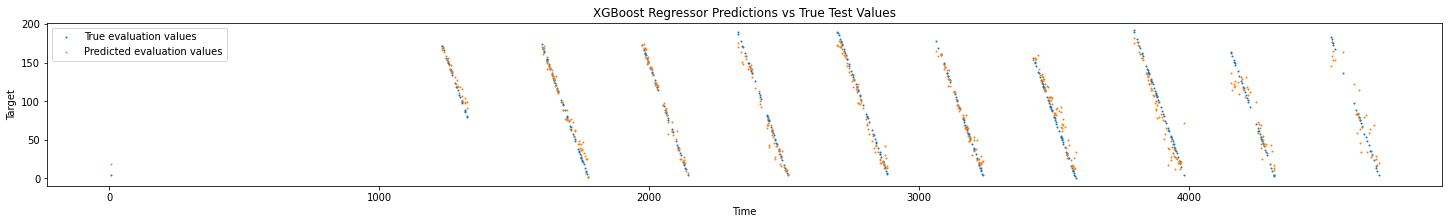

In [131]:
# XGB Regressor with baseline train & test sets
model = xgb.XGBRegressor()

# Define the hyperparameter grid for tuning
param_grid ={
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [5, 7, 9, 11, 13, 15],
    'min_child_weight': [1, 2, 4, 6, 8, 10], 
    'gamma': [0, 0.1, 0.5, 0.7, 1], 
    'subsample': [0.5, 0.7, 0.8, 0.9, 1], 
    'colsample_bytree': [0.5, 0.7, 0.8, 0.9, 1]
}

# Old params 
param_grid = {
'colsample_bytree': [0.9], 'gamma': [0], 'learning_rate': [0.05], 'max_depth': [15], 'min_child_weight': [10], 'subsample': [0.8]
}

# Define the grid search object
grid_search = GridSearchCV(model, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=5, scoring="neg_mean_absolute_error")

# Fit the grid search object to the training data
grid_search.fit(X_train_base, y_train_base)

# Print the best hyperparameters and the corresponding MAE score on the test set
print(f"Best hyperparameters_{y}: ", grid_search.best_params_)
print('------------------------------------------------------------------------------------')
# Save the best model parameters as 'model' variable
exec(f"xgb_model_{y} = grid_search.best_estimator_")

# Evaluate the best model on the test set
y_pred = eval(f"xgb_model_{y}").predict(X_test_base)
mae = mean_absolute_error(y_test_base, y_pred)
print("Average Mean Absolute Error test score from cv :", grid_search.cv_results_["mean_test_score"][0])
print("Standard deviation of Mean Absolute Error test scores from cv:", grid_search.cv_results_["std_test_score"][0])
mean_test_score = grid_search.cv_results_["mean_test_score"][0]
std_test_score = grid_search.cv_results_["std_test_score"][0]

best_estimator = grid_search.best_estimator_
plot_learning_curve(best_estimator, "Learning Curve (XGBRegressor)", X_train_base, y_train_base, cv=cv)
plt.show()

print('------------------------------------------------------------------------------------')
print(f"MAE on validation set ({y}): ", mae)

residuals = y_test_base - y_pred

plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot for XGBRegressor")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

for value, station_name in enumerate(station_names):
    print('------------------------------------------------------------------------------------')
    print(station_name)

    # Subset X_train and X_test with the values of station_names
    X_train_station = X_train_base.loc[X_train_base['stid'] == value]
    X_test_station = X_test_base.loc[X_test_base['stid'] == value]

    # Subset y_train and y_test with the indices of X_train_station and X_test_station
    y_train_station = y_train_base.loc[X_train_station.index]
    y_test_station = y_test_base.loc[X_test_station.index]

    y_pred_station = eval(f"xgb_model_{y}").predict(X_test_station)
    
    mae_station = mean_absolute_error(y_test_station, y_pred_station)
    
    print(f"Mean Absolute Error on test set ({y}): ", mae_station)
    
    plt.figure(figsize=(25, 3))
    plt.scatter(X_test_station.index, y_test_station, label="True evaluation values", alpha=1, s=1)
    plt.scatter(X_test_station.index, y_pred_station, label="Predicted evaluation values", alpha=1, s=1)
   
    plt.xlabel("Time")
    
    plt.ylabel("Target")
    plt.title("XGBoost Regressor Predictions vs True Test Values")
    plt.legend()
    plt.show()



Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters_event_time:  {'l2_regularization': 0.5, 'learning_rate': 0.1, 'max_depth': 3, 'max_iter': 100, 'min_samples_leaf': 1}
------------------------------------------------------------------------------------
Average R^2 test score from cv : 0.7106126748561554
Standard deviation of R^2 test scores from cv: 0.005257656915421687


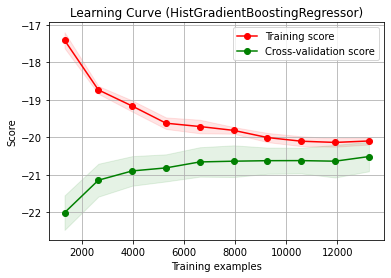

------------------------------------------------------------------------------------
R^2 score on validation set (event_time):  0.7090725327253244
MAE on validation set (event_time):  20.756886662350908


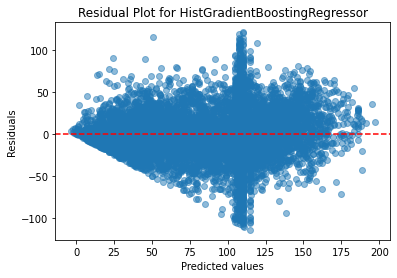

------------------------------------------------------------------------------------
KAN_L
R^2 score on test set (event_time):  0.8699218195103356
MAE on test set (event_time):  10.270456097441041


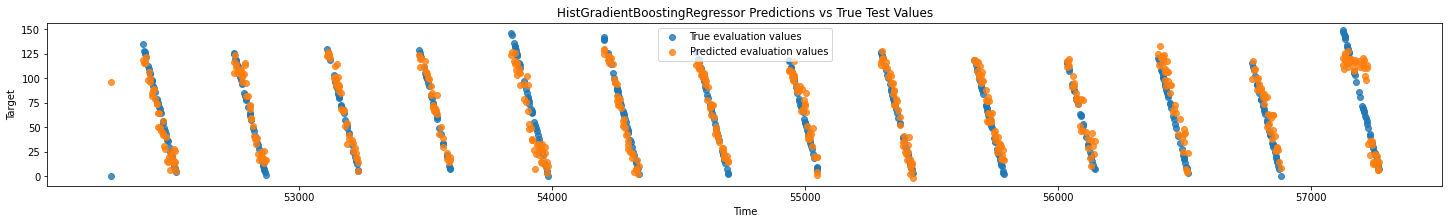

------------------------------------------------------------------------------------
KPC_L
R^2 score on test set (event_time):  0.763330688626121
MAE on test set (event_time):  16.735949592006097


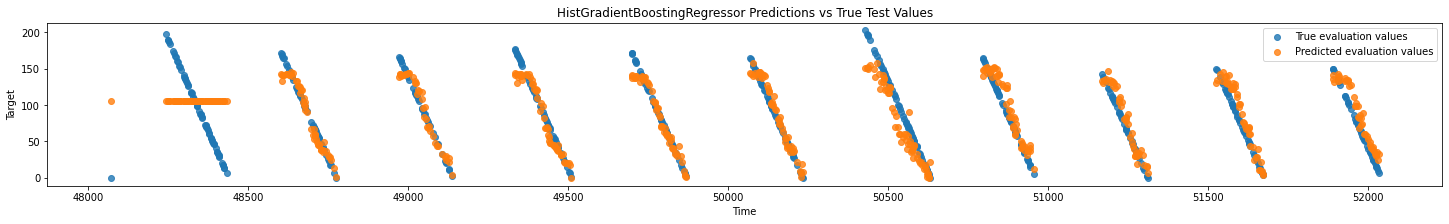

------------------------------------------------------------------------------------
MIT
R^2 score on test set (event_time):  0.6894560073032299
MAE on test set (event_time):  26.837070040001695


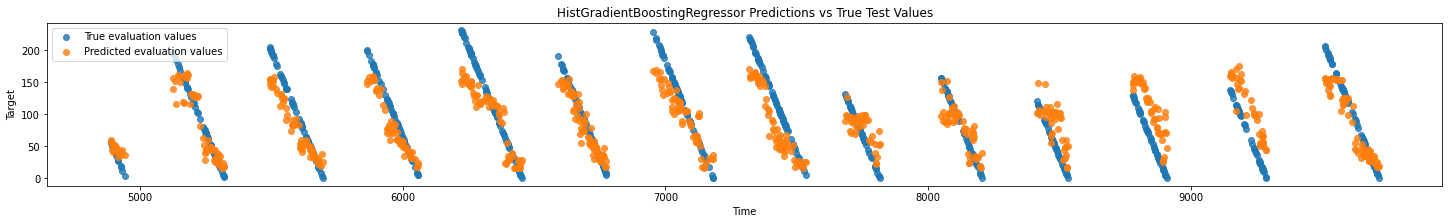

------------------------------------------------------------------------------------
NUK_L
R^2 score on test set (event_time):  0.6063551984771887
MAE on test set (event_time):  20.70669939086067


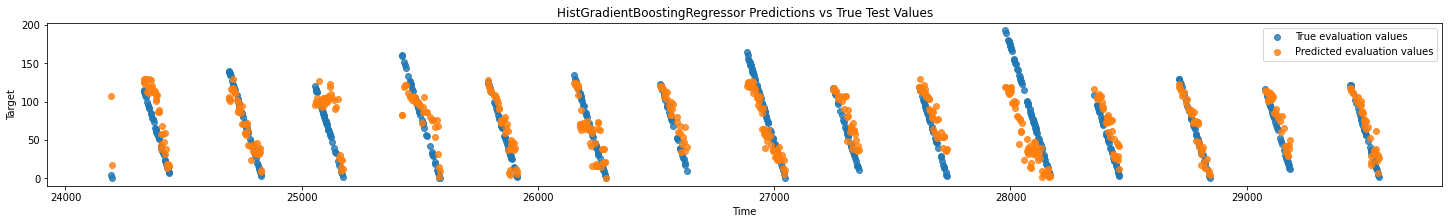

------------------------------------------------------------------------------------
NUK_U
R^2 score on test set (event_time):  0.4791510154891272
MAE on test set (event_time):  32.91116789268937


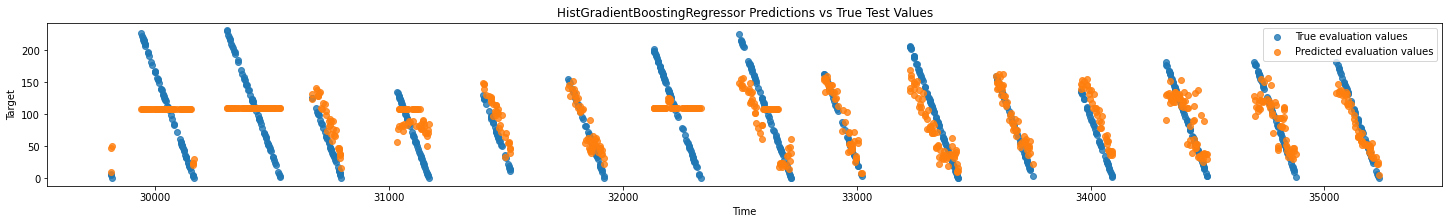

------------------------------------------------------------------------------------
QAS_L
R^2 score on test set (event_time):  0.7288197494781421
MAE on test set (event_time):  18.087447752362873


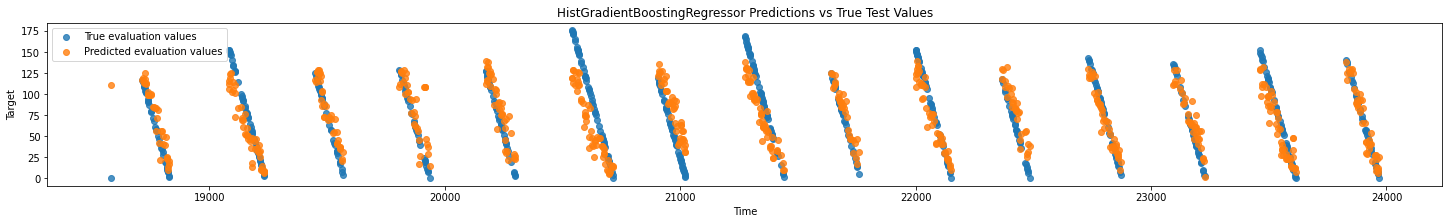

------------------------------------------------------------------------------------
QAS_U
R^2 score on test set (event_time):  0.7987975140006953
MAE on test set (event_time):  22.07681283353272


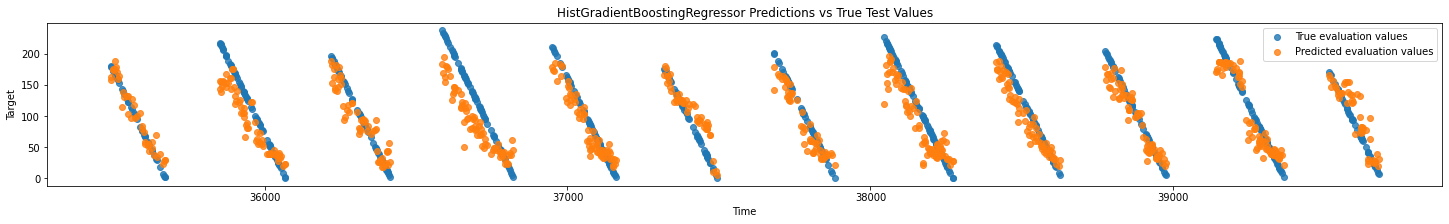

------------------------------------------------------------------------------------
SCO_L
R^2 score on test set (event_time):  0.8687601159230279
MAE on test set (event_time):  12.130893503124204


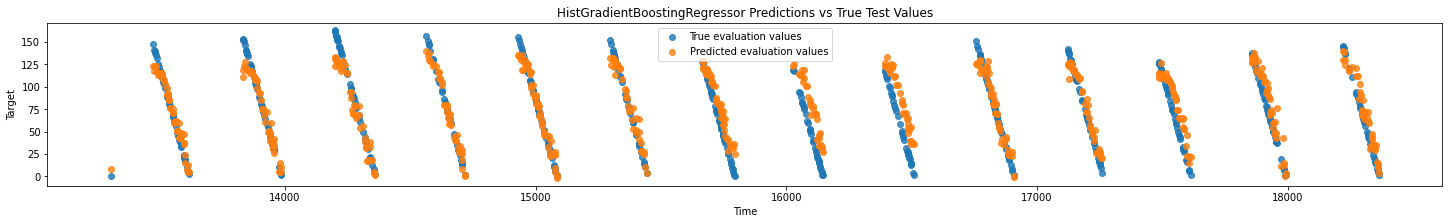

------------------------------------------------------------------------------------
SCO_U
R^2 score on test set (event_time):  0.7136095845209207
MAE on test set (event_time):  19.095209525656795


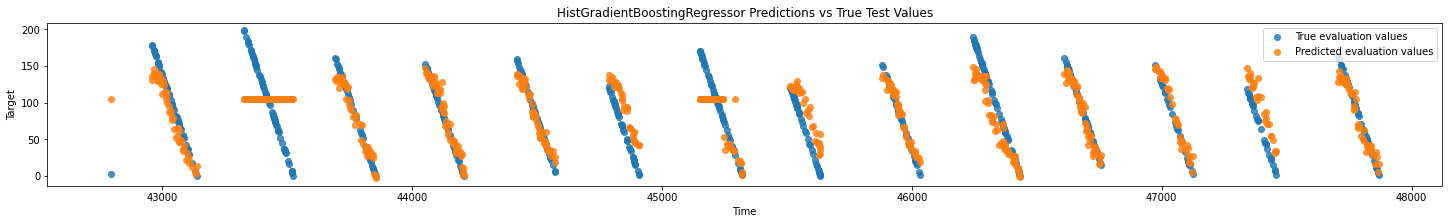

------------------------------------------------------------------------------------
TAS_L
R^2 score on test set (event_time):  0.38797134407644307
MAE on test set (event_time):  31.602692523915604


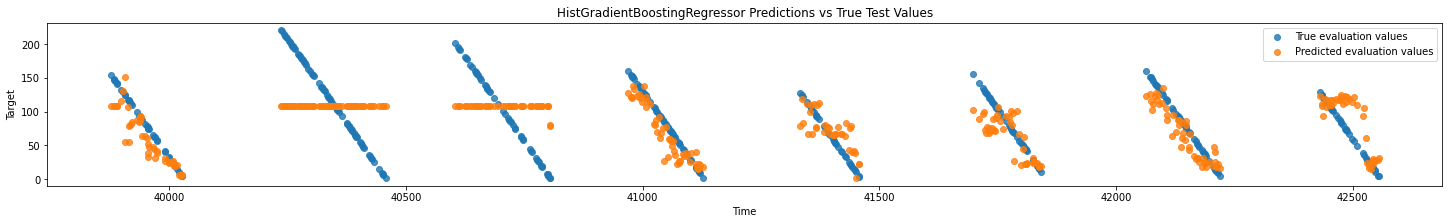

------------------------------------------------------------------------------------
THU_L
R^2 score on test set (event_time):  0.706642745326178
MAE on test set (event_time):  21.31641088587621


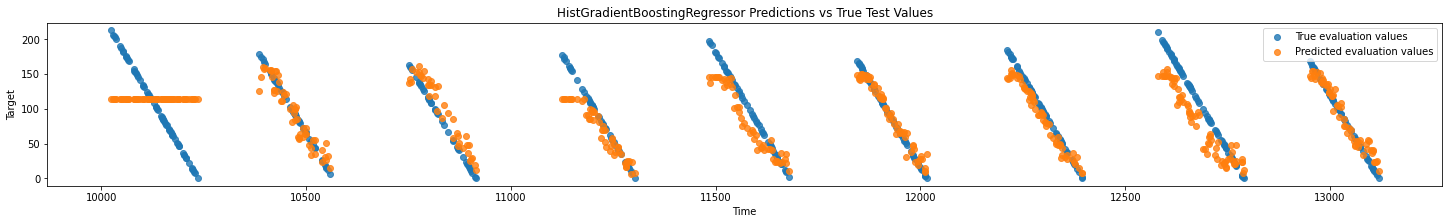

------------------------------------------------------------------------------------
UPE_L
R^2 score on test set (event_time):  0.6950365101745695
MAE on test set (event_time):  18.008182769429162


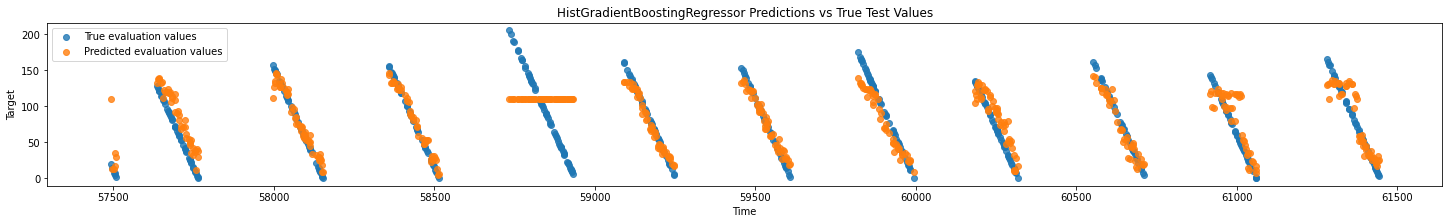

------------------------------------------------------------------------------------
UPE_U
R^2 score on test set (event_time):  0.8169096593745423
MAE on test set (event_time):  17.516674358512596


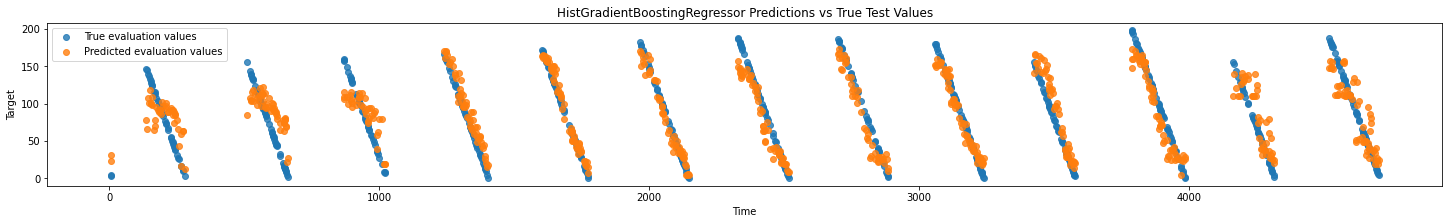

In [132]:
# This bit to find best HistGradientBoostingRegressor model for when Ablation == True and for both target variables
model = HistGradientBoostingRegressor()

# Old params
param_grid = {
    'max_depth': [3],
    'min_samples_leaf': [1],
    'learning_rate': [0.1],
    'max_iter': [100],
    'l2_regularization': [0.5]
}

# Define the grid search object
grid_search = GridSearchCV(model, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=5)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding R^2 score on the test set
print(f"Best hyperparameters_{y}: ", grid_search.best_params_)
print('------------------------------------------------------------------------------------')
# Save the best model parameters as 'model' variable
exec(f"hist_model_{y} = grid_search.best_estimator_")

# Evaluate the best model on the test set
y_pred = eval(f"hist_model_{y}").predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Average R^2 test score from cv :", grid_search.cv_results_["mean_test_score"][0])
print("Standard deviation of R^2 test scores from cv:", grid_search.cv_results_["std_test_score"][0])
mean_test_score = grid_search.cv_results_["mean_test_score"][0]
std_test_score = grid_search.cv_results_["std_test_score"][0]

plot_learning_curve(grid_search.best_estimator_, "Learning Curve (HistGradientBoostingRegressor)", X_train, y_train, cv=cv)
plt.show()

print('------------------------------------------------------------------------------------')
print(f"R^2 score on validation set ({y}): ", r2)
print(f"MAE on validation set ({y}): ", mae)

residuals = y_test - y_pred

plt.scatter(y_pred, residuals, alpha=0.5)
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.title("Residual Plot for HistGradientBoostingRegressor")
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

for value, station_name in enumerate(station_names):
    print('------------------------------------------------------------------------------------')
    print(station_name)

    # Subset X_train and X_test with the values of station_names
    X_train_station = X_train.loc[X_train['stid'] == value]
    X_test_station = X_test.loc[X_test['stid'] == value]

    # Subset y_train and y_test with the indices of X_train_station and X_test_station
    y_train_station = y_train.loc[X_train_station.index]
    y_test_station = y_test.loc[X_test_station.index]

    y_pred_station = eval(f"hist_model_{y}").predict(X_test_station)
    
    r2_station = r2_score(y_test_station, y_pred_station)
    mae_station = mean_absolute_error(y_test_station, y_pred_station)
    
    print(f"R^2 score on test set ({y}): ", r2_station)
    print(f"MAE on test set ({y}): ", mae_station)
    
    plt.figure(figsize=(25, 3))
    plt.scatter(X_test_station.index, y_test_station, label="True evaluation values", alpha=0.8)
    plt.scatter(X_test_station.index, y_pred_station, label="Predicted evaluation values", alpha=0.8)
    plt.xlabel("Time")
    plt.ylabel("Target")
    plt.title("HistGradientBoostingRegressor Predictions vs True Test Values")
    plt.legend()
    plt.show()



Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best hyperparameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
Average Mean Absolute Error test score from cv : 0.11542058771103332
Standard deviation of Mean Absolute Error test scores from cv: 0.03217693472578749


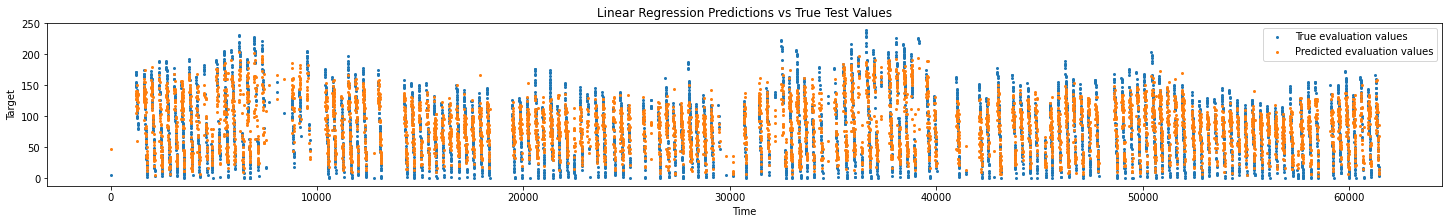

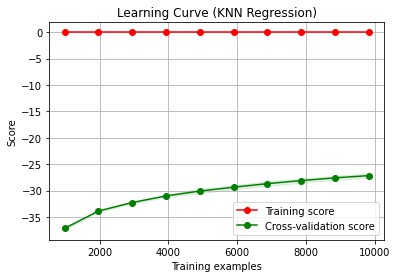

------------------------------------------------------------------------------------
KAN_L
R^2 score on test set (event_time):  0.4353699239420472
MAE on test set (event_time):  22.60335676029977


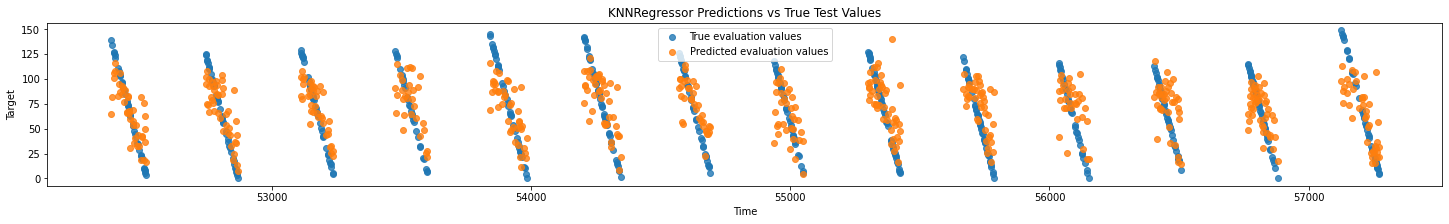

------------------------------------------------------------------------------------
KPC_L
R^2 score on test set (event_time):  0.525248027464436
MAE on test set (event_time):  27.024499678514854


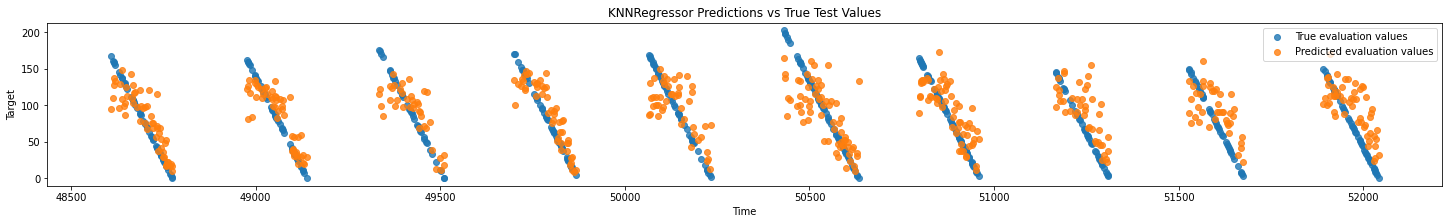

------------------------------------------------------------------------------------
MIT
R^2 score on test set (event_time):  0.5161352828362129
MAE on test set (event_time):  34.514940542438254


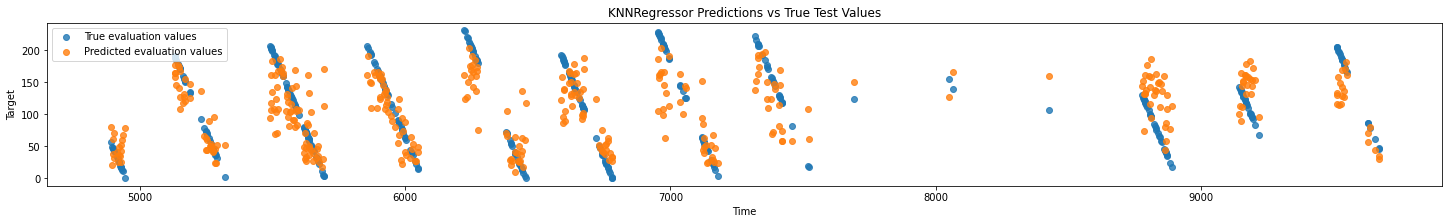

------------------------------------------------------------------------------------
NUK_L
R^2 score on test set (event_time):  0.30319308221700403
MAE on test set (event_time):  27.27070739496937


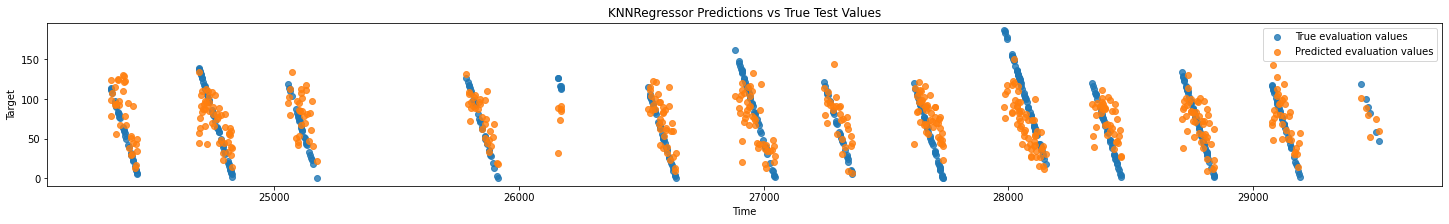

------------------------------------------------------------------------------------
NUK_U
R^2 score on test set (event_time):  0.5582173470613735
MAE on test set (event_time):  27.526037400834433


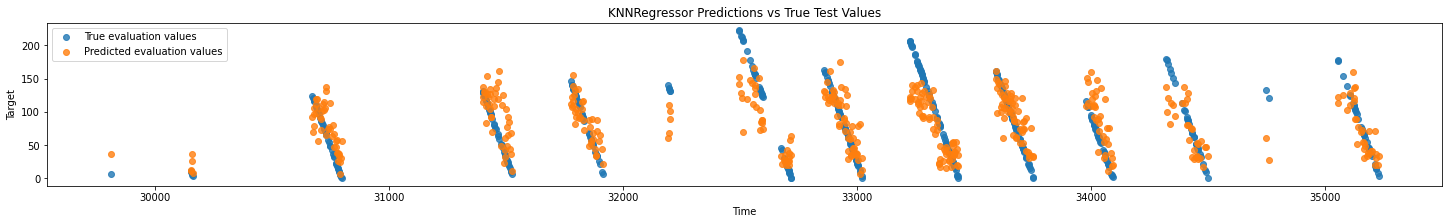

------------------------------------------------------------------------------------
QAS_L
R^2 score on test set (event_time):  0.3811856965854006
MAE on test set (event_time):  29.096361422304636


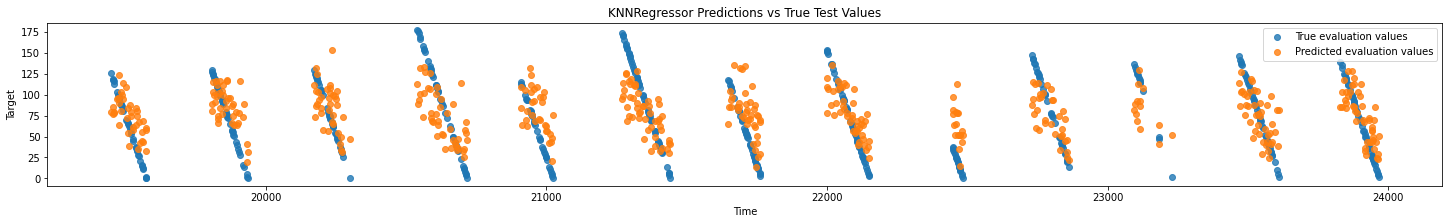

------------------------------------------------------------------------------------
QAS_U
R^2 score on test set (event_time):  0.7142073916346712
MAE on test set (event_time):  27.235978016673105


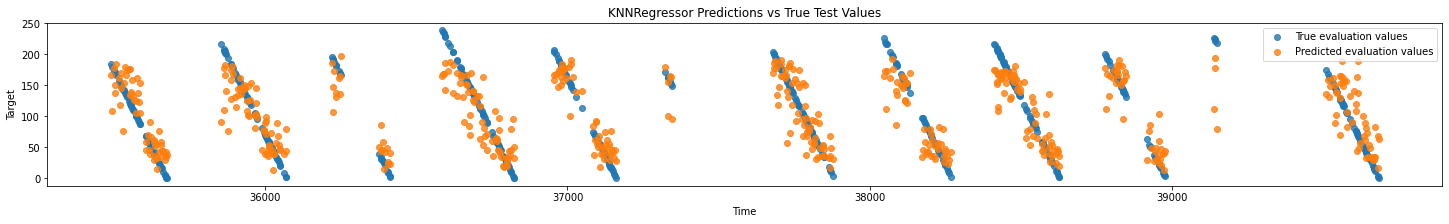

------------------------------------------------------------------------------------
SCO_L
R^2 score on test set (event_time):  0.4716832003953907
MAE on test set (event_time):  24.586424704817464


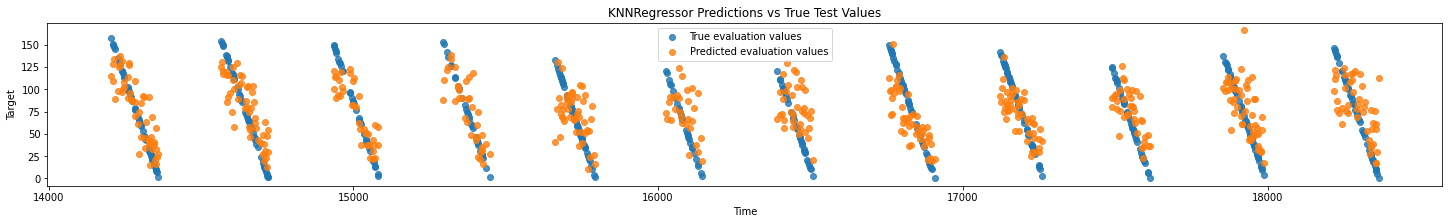

------------------------------------------------------------------------------------
SCO_U
R^2 score on test set (event_time):  0.609179962827711
MAE on test set (event_time):  23.00098535851322


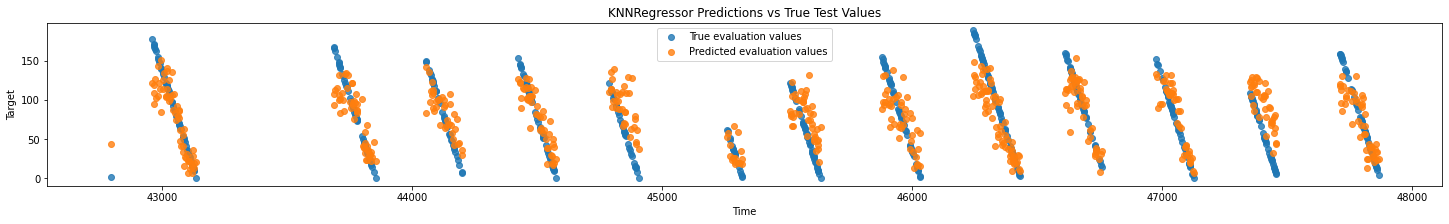

------------------------------------------------------------------------------------
TAS_L
R^2 score on test set (event_time):  0.23118693008389557
MAE on test set (event_time):  31.37194011773193


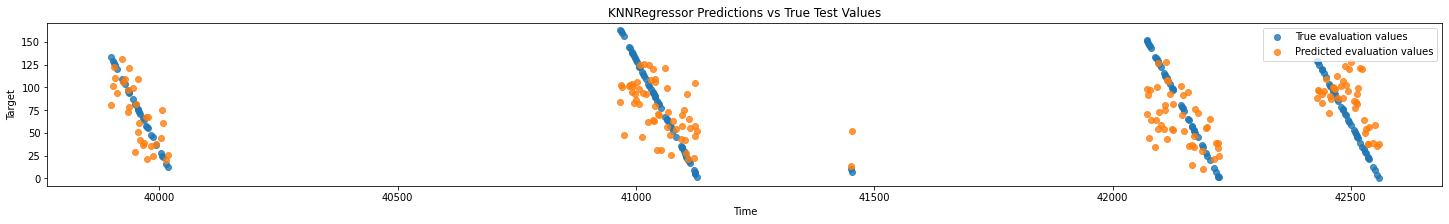

------------------------------------------------------------------------------------
THU_L
R^2 score on test set (event_time):  0.6975565603204331
MAE on test set (event_time):  21.6198431886896


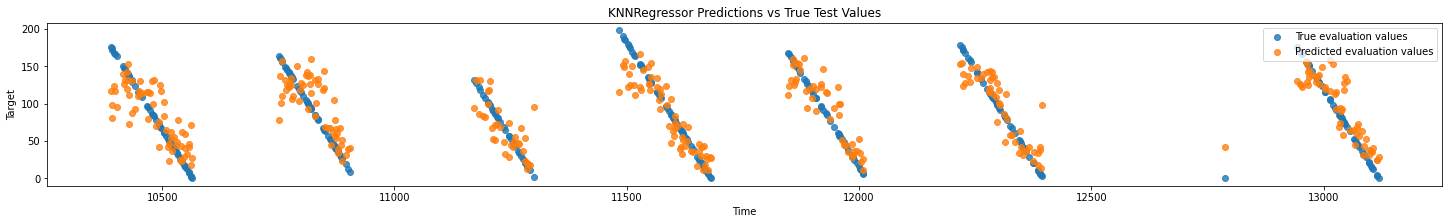

------------------------------------------------------------------------------------
UPE_L
R^2 score on test set (event_time):  0.531701530277502
MAE on test set (event_time):  26.00313756301378


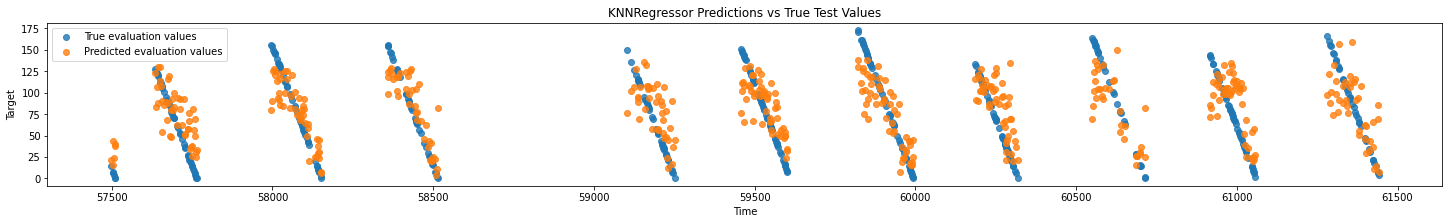

------------------------------------------------------------------------------------
UPE_U
R^2 score on test set (event_time):  0.712132864215119
MAE on test set (event_time):  21.337894748333305


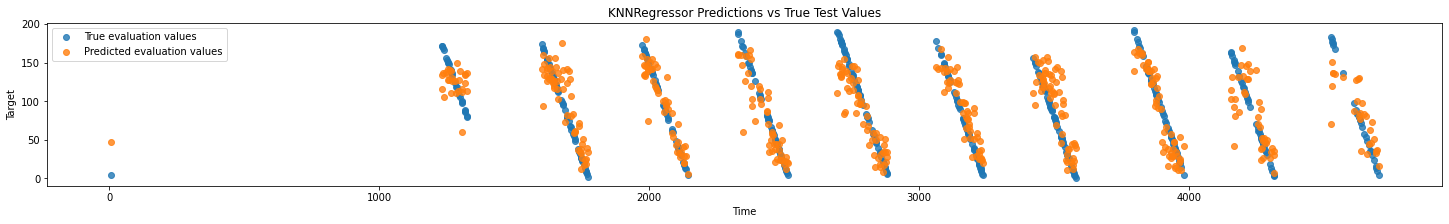

In [134]:
from sklearn.neighbors import KNeighborsRegressor

# Create the k-Nearest Neighbors Regressor
knn_model = KNeighborsRegressor()

# Define hyperparameter search space
param_grid = {
    'n_neighbors': range(1, 11),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Create grid search object
grid_search = GridSearchCV(knn_model, param_grid, cv=cv, n_jobs=-1, verbose = 2)

# Fit the grid search object to the training data
grid_search.fit(X_train_base, y_train_base)

best_knn_model = grid_search.best_estimator_
best_estimator = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred_base = best_knn_model.predict(X_test_base)

mae = mean_absolute_error(y_test_base, y_pred_base)

print("Best hyperparameters:", grid_search.best_params_)
print("Average Mean Absolute Error test score from cv :", grid_search.cv_results_["mean_test_score"][0])
print("Standard deviation of Mean Absolute Error test scores from cv:", grid_search.cv_results_["std_test_score"][0])

plt.figure(figsize=(25, 3))
plt.scatter(X_test_base.index, y_test_base, label="True evaluation values", alpha=1, s=4)
plt.scatter(X_test_base.index, y_pred_base, label="Predicted evaluation values", alpha=1, s=4)

plt.xlabel("Time")
plt.ylabel("Target")
plt.title("Linear Regression Predictions vs True Test Values")
plt.legend()
plt.show()

plot_learning_curve(best_estimator, "Learning Curve (KNN Regression)", X_train_base, y_train_base, cv=cv)
plt.show()


for value, station_name in enumerate(station_names):
    print('------------------------------------------------------------------------------------')
    print(station_name)

    # Subset X_train and X_test with the values of station_names
    X_train_station = X_train_base.loc[X_train_base['stid'] == value]
    X_test_station = X_test_base.loc[X_test_base['stid'] == value]

    # Subset y_train and y_test with the indices of X_train_station and X_test_station
    y_train_station = y_train_base.loc[X_train_station.index]
    y_test_station = y_test_base.loc[X_test_station.index]

    y_pred_station = best_knn_model.predict(X_test_station)
    
    r2_station = r2_score(y_test_station, y_pred_station)
    mae_station = mean_absolute_error(y_test_station, y_pred_station)
    
    print(f"R^2 score on test set ({y}): ", r2_station)
    print(f"MAE on test set ({y}): ", mae_station)
    
    plt.figure(figsize=(25, 3))
    plt.scatter(X_test_station.index, y_test_station, label="True evaluation values", alpha=0.8)
    plt.scatter(X_test_station.index, y_pred_station, label="Predicted evaluation values", alpha=0.8)
   
    plt.xlabel("Time")
    plt.ylabel("Target")
    plt.title("KNNRegressor Predictions vs True Test Values")
    plt.legend()
    plt.show()

---------

## SHAP Analysis

In [135]:
import shap

explainer = eval(f"shap.Explainer(xgb_model_{y})")

In [ ]:
X_set = pd.concat([X_train, X_test])
X = X_set

positive_color = "#ca0020"
negative_color = "#92c5de"

shap_values = explainer(X_set)

In [ ]:
shap.summary_plot(shap_values, X, plot_type='bar', plot_size = (8,4))

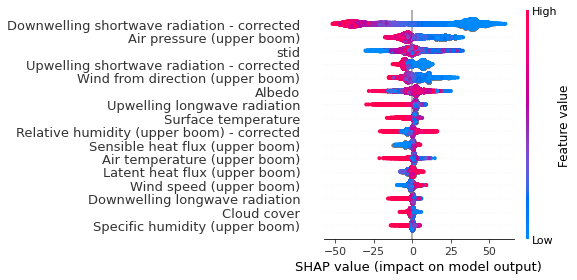

In [139]:
shap.summary_plot(shap_values, X, plot_type="dot", plot_size = (8,4))

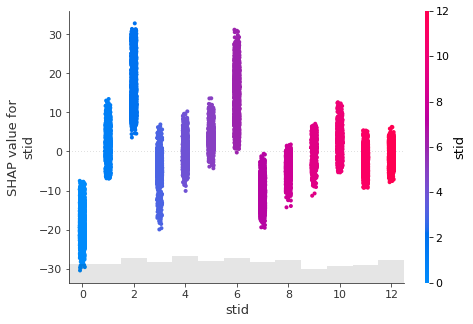

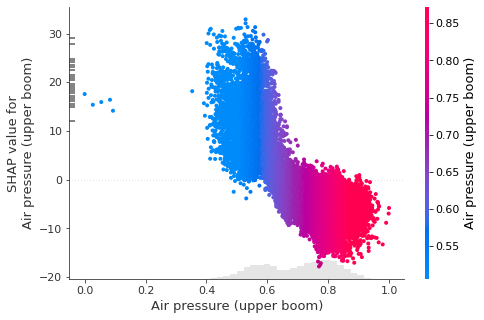

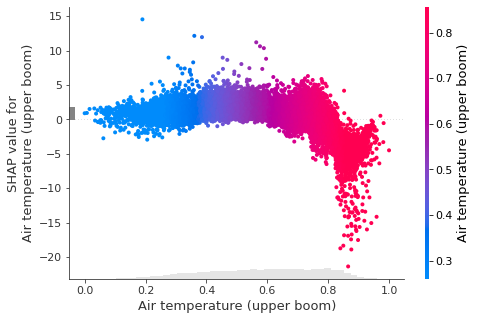

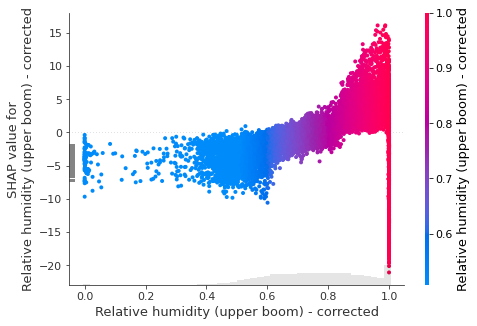

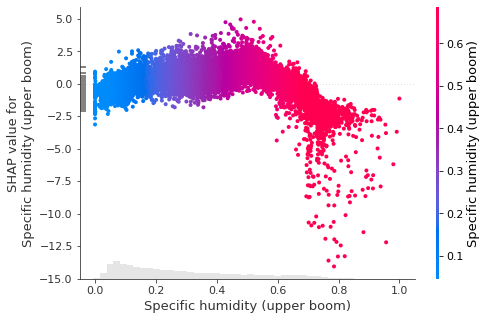

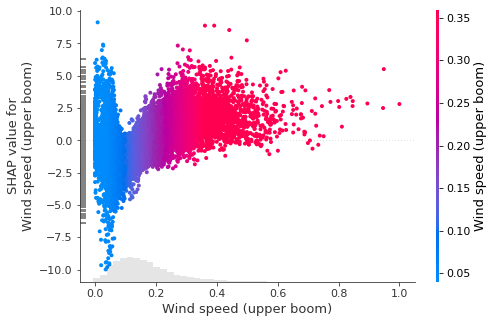

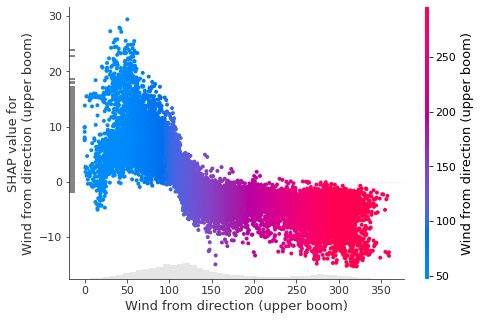

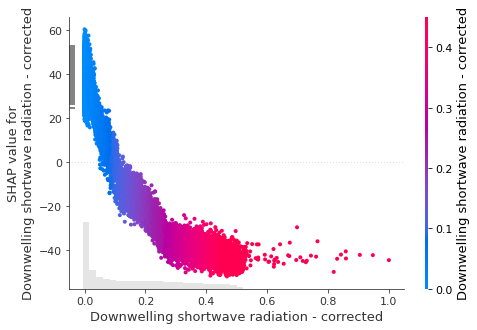

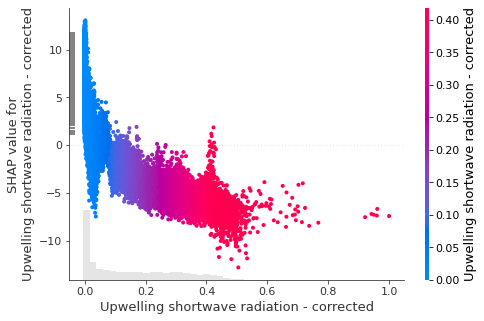

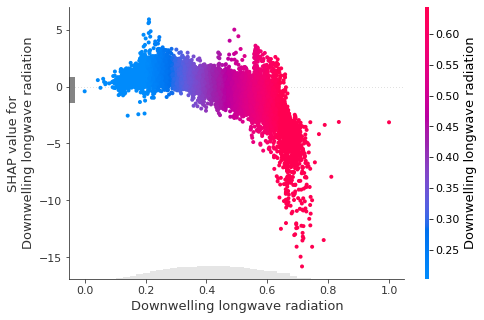

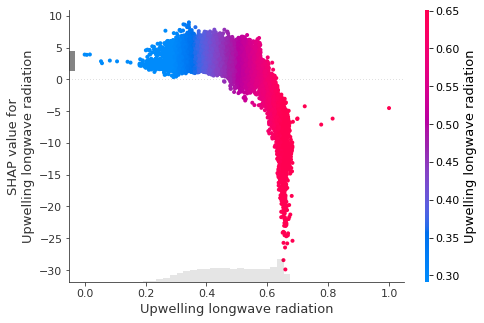

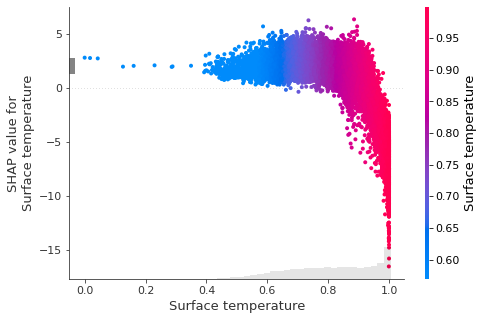

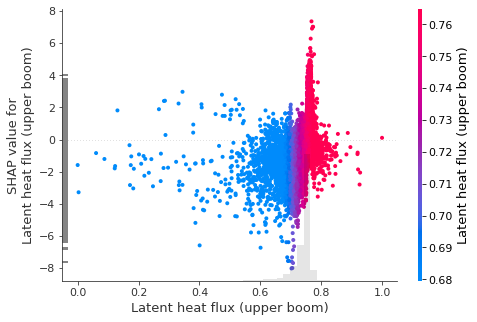

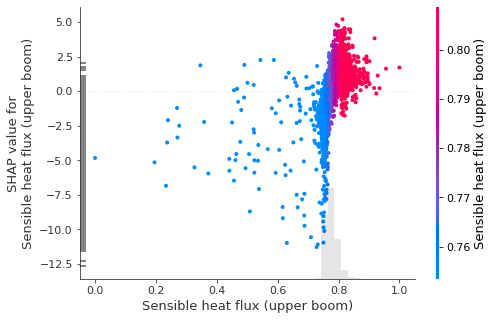

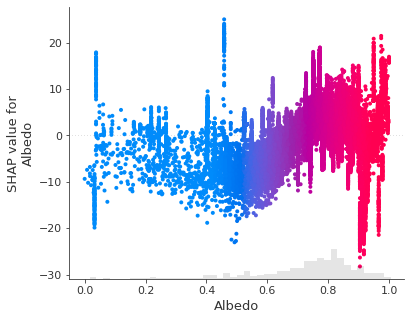

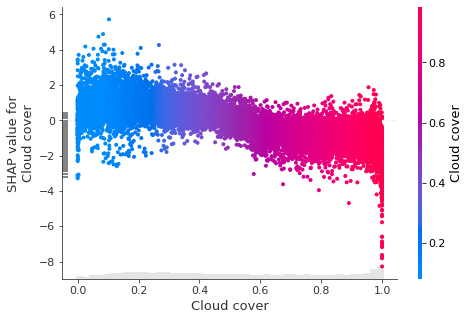

IndexError: index 16 is out of bounds for axis 1 with size 16

In [141]:
for i in range(16):
    shap.plots.scatter(shap_values[:,i], color=shap_values[:,i])

This bit to automatically save all plots on your desktop

In [ ]:
import os

#Specify the generic name of the plot
name = "melt-onst-day"

# Save the bar plot
plt.figure()
shap.summary_plot(shap_values, X, plot_type='bar', plot_size=(8, 4))

fig = plt.gcf()
plt.savefig(os.path.expanduser('~/Desktop/{}_bar.png'.format(name)))
plt.close(fig)

# Save the dot plot
plt.figure()
shap.summary_plot(shap_values, X, plot_type="dot", plot_size=(8, 4))
fig = plt.gcf()
plt.savefig(os.path.expanduser('~/Desktop/{}_dot.png'.format(name)))
plt.close(fig)

for i in range(17):
    # Create a new Explanation object with the desired feature's SHAP values
    single_feature_shap_values = shap.Explanation(
        shap_values[:, i].reshape(-1, 1),
        explainer.expected_value,
        X_set.loc[filter].values[:, i].reshape(-1, 1),
        feature_names=[X_set.columns[i]]
    )

    # Save the scatter plot
    shap.plots.scatter(single_feature_shap_values, show=False, color=single_feature_shap_values)
    fig = plt.gcf()
    plt.savefig(os.path.expanduser('~/Desktop/{}_scatter_{}.png'.format(name, i)))
    plt.close(fig)


-------